## pipeline 

In [ ]:
import os
import subprocess
import nibabel as nib
import numpy as np
import time

os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30088_MR_d0093/func2/NIFTI/sub-OAS30088_ses-d0093_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30088_MR_d0093/anat2/NIFTI/sub-OAS30088_ses-d0093_run-01_T1w.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'

os.makedirs(output_dir, exist_ok=True)

# Load fMRI data
fmri_img = nib.load(fmri_file)
fmri_data = fmri_img.get_fdata()

print("Starting BET brain extraction...")
start_time = time.time()
first_volume = nib.Nifti1Image(fmri_data[..., 0], fmri_img.affine, fmri_img.header)
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_path)

bet_output = os.path.join(output_dir, "bet_output")
bet_command = f"bet {first_volume_path} {bet_output} -F -f 0.5 -m"
subprocess.run(bet_command, shell=True, check=True)
print(f"BET brain extraction completed in {time.time() - start_time:.2f} seconds")

mask_img = nib.load(f"{bet_output}_mask.nii.gz")
mask_data = mask_img.get_fdata()
masked_fmri_data = fmri_data * mask_data[..., np.newaxis]
masked_fmri_img = nib.Nifti1Image(masked_fmri_data, fmri_img.affine, fmri_img.header)
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")
nib.save(masked_fmri_img, masked_fmri_path)

print("Starting MCFLIRT motion correction...")
start_time = time.time()
mcflirt_output = os.path.join(output_dir, "mcflirt_output")
mcflirt_command = f"mcflirt -in {masked_fmri_path} -out {mcflirt_output} -plots"
subprocess.run(mcflirt_command, shell=True, check=True)
print(f"MCFLIRT motion correction completed in {time.time() - start_time:.2f} seconds")

motion_corrected_fmri = f"{mcflirt_output}.nii.gz"

print("Starting FLIRT registration...")
start_time = time.time()

mc_fmri_img = nib.load(motion_corrected_fmri)
mc_first_volume = nib.Nifti1Image(mc_fmri_img.get_fdata()[..., 0], mc_fmri_img.affine, mc_fmri_img.header)
mc_first_volume_path = os.path.join(output_dir, "mc_first_volume.nii.gz")
nib.save(mc_first_volume, mc_first_volume_path)

flirt_mat_output = os.path.join(output_dir, "func_to_struct.mat")
flirt_command = f"flirt -in {mc_first_volume_path} -ref {t1_file} -omat {flirt_mat_output} -cost corratio -dof 6"
subprocess.run(flirt_command, shell=True, check=True)

flirt_output = os.path.join(output_dir, "func_to_struct")
apply_xfm_command = f"applywarp --in={motion_corrected_fmri} --ref={t1_file} --premat={flirt_mat_output} --out={flirt_output}"
subprocess.run(apply_xfm_command, shell=True, check=True)
print(f"FLIRT registration and application completed in {time.time() - start_time:.2f} seconds")

print("Starting FNIRT registration...")
start_time = time.time()
fnirt_output = os.path.join(output_dir, "func_to_mni")
fnirt_command = f"fnirt --in={t1_file} --ref={mni_template} --aff={flirt_mat_output} --cout={fnirt_output}_warp"
subprocess.run(fnirt_command, shell=True, check=True)
print(f"FNIRT registration completed in {time.time() - start_time:.2f} seconds")

print("Applying warp to fMRI data...")
start_time = time.time()
apply_warp_command = f"applywarp --in={flirt_output} --ref={mni_template} --warp={fnirt_output}_warp --out={fnirt_output}"
subprocess.run(apply_warp_command, shell=True, check=True)
print(f"Warp application completed in {time.time() - start_time:.2f} seconds")

print("fMRI preprocessing pipeline completed successfully.")

In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

# 결과 파일들의 경로 설정
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'
bet_output = os.path.join(output_dir, "bet_output.nii.gz")
mcflirt_output = os.path.join(output_dir, "mcflirt_output.nii.gz")
flirt_output = os.path.join(output_dir, "func_to_struct.nii.gz")
fnirt_output = os.path.join(output_dir, "func_to_mni.nii.gz")

# 결과 이미지 로드 및 첫 번째 볼륨 추출
bet_img = nib.load(bet_output)
mcflirt_img = nib.load(mcflirt_output)
flirt_img = nib.load(flirt_output)
fnirt_img = nib.load(fnirt_output)

# 첫 번째 볼륨 추출 함수
def get_first_volume(img):
    data = img.get_fdata()
    if len(data.shape) > 3:
        return img.__class__(data[..., 0], img.affine, img.header)
    return img

# 각 결과의 첫 번째 볼륨 추출
bet_first = get_first_volume(bet_img)
mcflirt_first = get_first_volume(mcflirt_img)
flirt_first = get_first_volume(flirt_img)
fnirt_first = get_first_volume(fnirt_img)

# 각 결과를 개별적으로 크게 시각화
plt.figure(figsize=(12, 10))
plotting.plot_anat(bet_first, title="BET Result (First Volume)", display_mode='ortho')
plt.show()

plt.figure(figsize=(12, 10))
plotting.plot_anat(mcflirt_first, title="MCFLIRT Result (First Volume)", display_mode='ortho')
plt.show()

plt.figure(figsize=(12, 10))
plotting.plot_anat(flirt_first, title="FLIRT Result (First Volume)", display_mode='ortho')
plt.show()

plt.figure(figsize=(12, 10))
plotting.plot_anat(fnirt_first, title="FNIRT Result (First Volume)", display_mode='ortho')
plt.show()

print("Visualization of first volumes completed. Results displayed on screen.")

In [16]:
# 8.2

In [13]:
import os
import subprocess
import nibabel as nib
import numpy as np
import time

os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/func2/NIFTI/sub-OAS30064_ses-d0687_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/anat2/NIFTI/sub-OAS30064_ses-d0687_run-01_T1w.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample2'

os.makedirs(output_dir, exist_ok=True)

fmri_img = nib.load(fmri_file)
fmri_data = fmri_img.get_fdata()

print("Starting BET brain extraction...")
start_time = time.time()
first_volume = nib.Nifti1Image(fmri_data[..., 0], fmri_img.affine, fmri_img.header)
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_path)

bet_output = os.path.join(output_dir, "bet_output")
bet_command = f"bet {first_volume_path} {bet_output} -F -f 0.5 -m"
subprocess.run(bet_command, shell=True, check=True)
print(f"BET brain extraction completed in {time.time() - start_time:.2f} seconds")

mask_img = nib.load(f"{bet_output}_mask.nii.gz")
mask_data = mask_img.get_fdata()
masked_fmri_data = fmri_data * mask_data[..., np.newaxis]
masked_fmri_img = nib.Nifti1Image(masked_fmri_data, fmri_img.affine, fmri_img.header)
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")
nib.save(masked_fmri_img, masked_fmri_path)

print("Starting MCFLIRT motion correction...")
start_time = time.time()
mcflirt_output = os.path.join(output_dir, "mcflirt_output")
mcflirt_command = f"mcflirt -in {masked_fmri_path} -out {mcflirt_output} -plots"
subprocess.run(mcflirt_command, shell=True, check=True)
print(f"MCFLIRT motion correction completed in {time.time() - start_time:.2f} seconds")


motion_corrected_fmri = f"{mcflirt_output}.nii.gz"

print("Starting FLIRT registration...")
start_time = time.time()

mc_fmri_img = nib.load(motion_corrected_fmri)
mc_first_volume = nib.Nifti1Image(mc_fmri_img.get_fdata()[..., 0], mc_fmri_img.affine, mc_fmri_img.header)
mc_first_volume_path = os.path.join(output_dir, "mc_first_volume.nii.gz")
nib.save(mc_first_volume, mc_first_volume_path)

flirt_mat_output = os.path.join(output_dir, "func_to_struct.mat")
flirt_command = f"flirt -in {mc_first_volume_path} -ref {t1_file} -omat {flirt_mat_output} -cost corratio -dof 6"
subprocess.run(flirt_command, shell=True, check=True)

flirt_output = os.path.join(output_dir, "func_to_struct")
apply_xfm_command = f"applywarp --in={motion_corrected_fmri} --ref={t1_file} --premat={flirt_mat_output} --out={flirt_output}"
subprocess.run(apply_xfm_command, shell=True, check=True)
print(f"FLIRT registration and application completed in {time.time() - start_time:.2f} seconds")

print("Starting FNIRT registration...")
start_time = time.time()
fnirt_output = os.path.join(output_dir, "func_to_mni")
fnirt_command = f"fnirt --in={t1_file} --ref={mni_template} --aff={flirt_mat_output} --cout={fnirt_output}_warp"
subprocess.run(fnirt_command, shell=True, check=True)
print(f"FNIRT registration completed in {time.time() - start_time:.2f} seconds")

print("Applying warp to fMRI data...")
start_time = time.time()
apply_warp_command = f"applywarp --in={flirt_output} --ref={mni_template} --warp={fnirt_output}_warp --out={fnirt_output}"
subprocess.run(apply_warp_command, shell=True, check=True)
print(f"Warp application completed in {time.time() - start_time:.2f} seconds")

print("fMRI preprocessing pipeline completed successfully.")

Starting BET brain extraction...
BET brain extraction completed in 0.72 seconds
Starting MCFLIRT motion correction...
MCFLIRT motion correction completed in 16.95 seconds
Starting FLIRT registration...
FLIRT registration and application completed in 696.70 seconds
Starting FNIRT registration...
FNIRT registration completed in 586.01 seconds
Applying warp to fMRI data...
Warp application completed in 399.01 seconds
fMRI preprocessing pipeline completed successfully.


/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/tmp/ipykernel_56786/2029235058.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


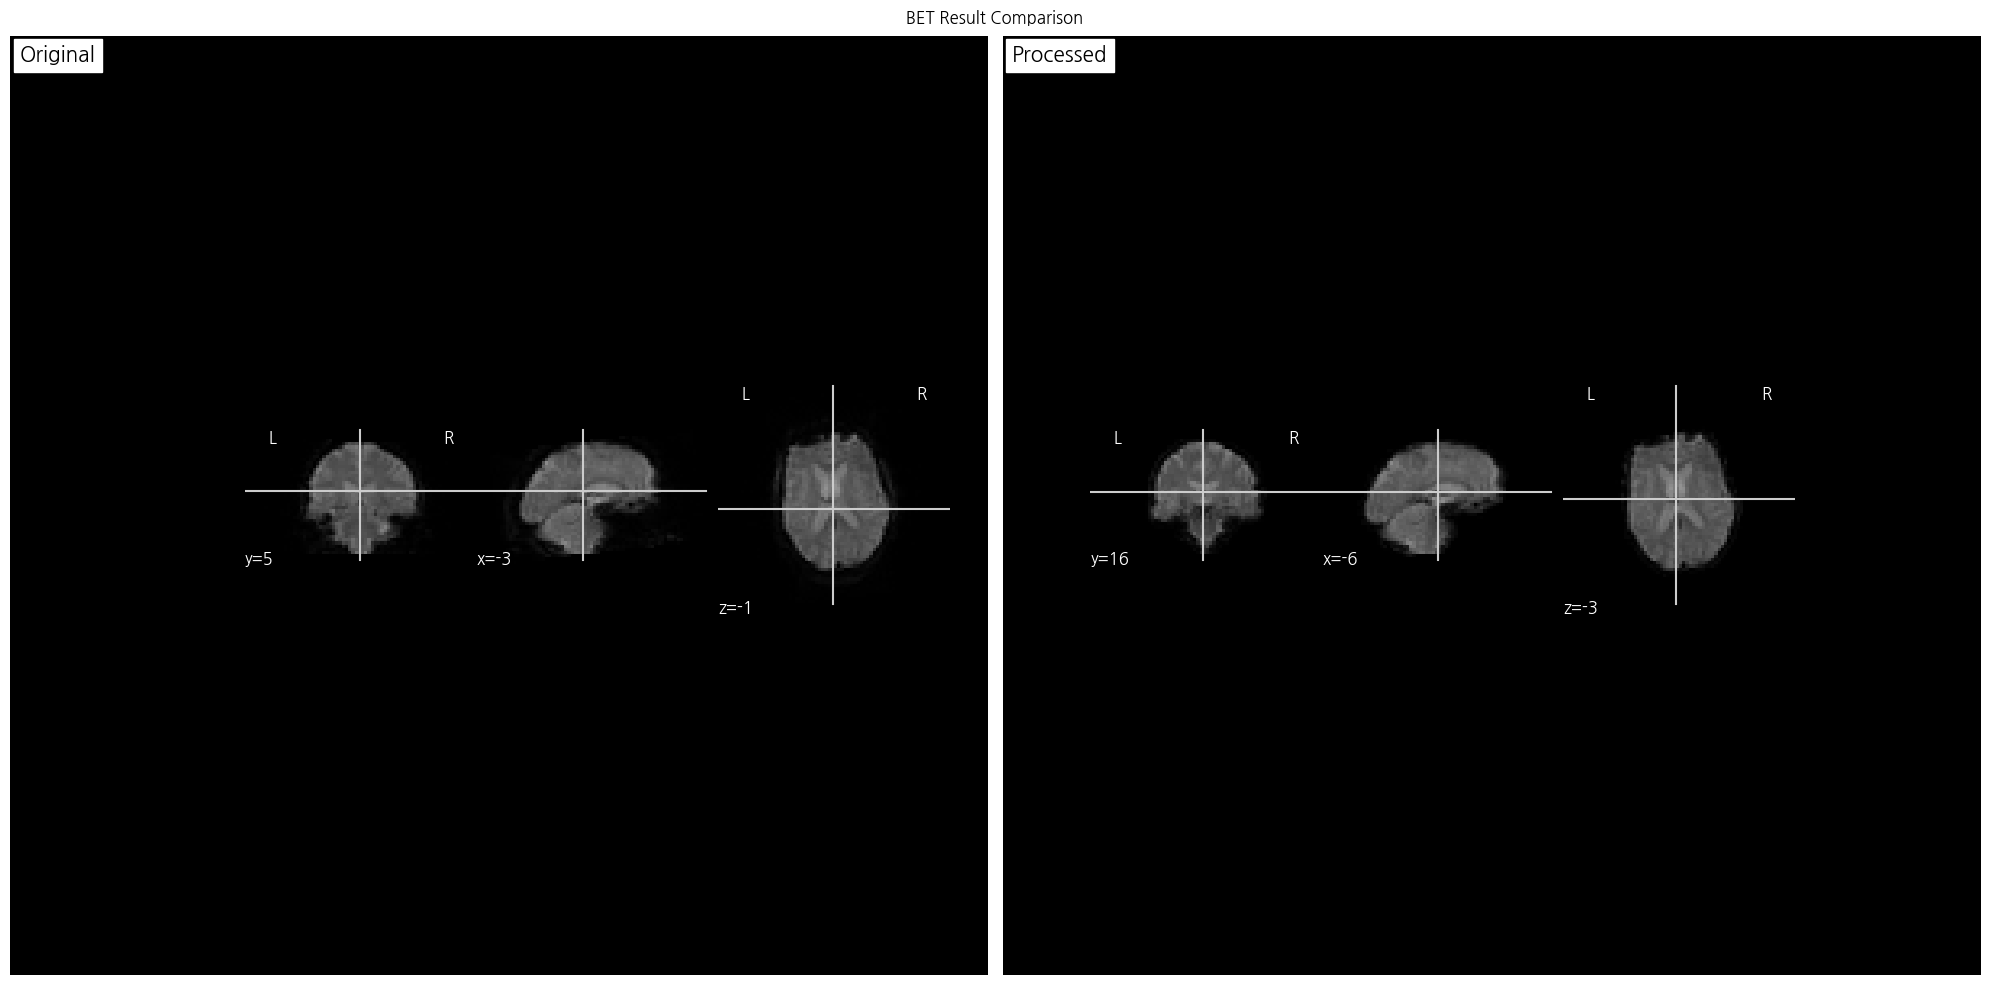

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/tmp/ipykernel_56786/2029235058.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


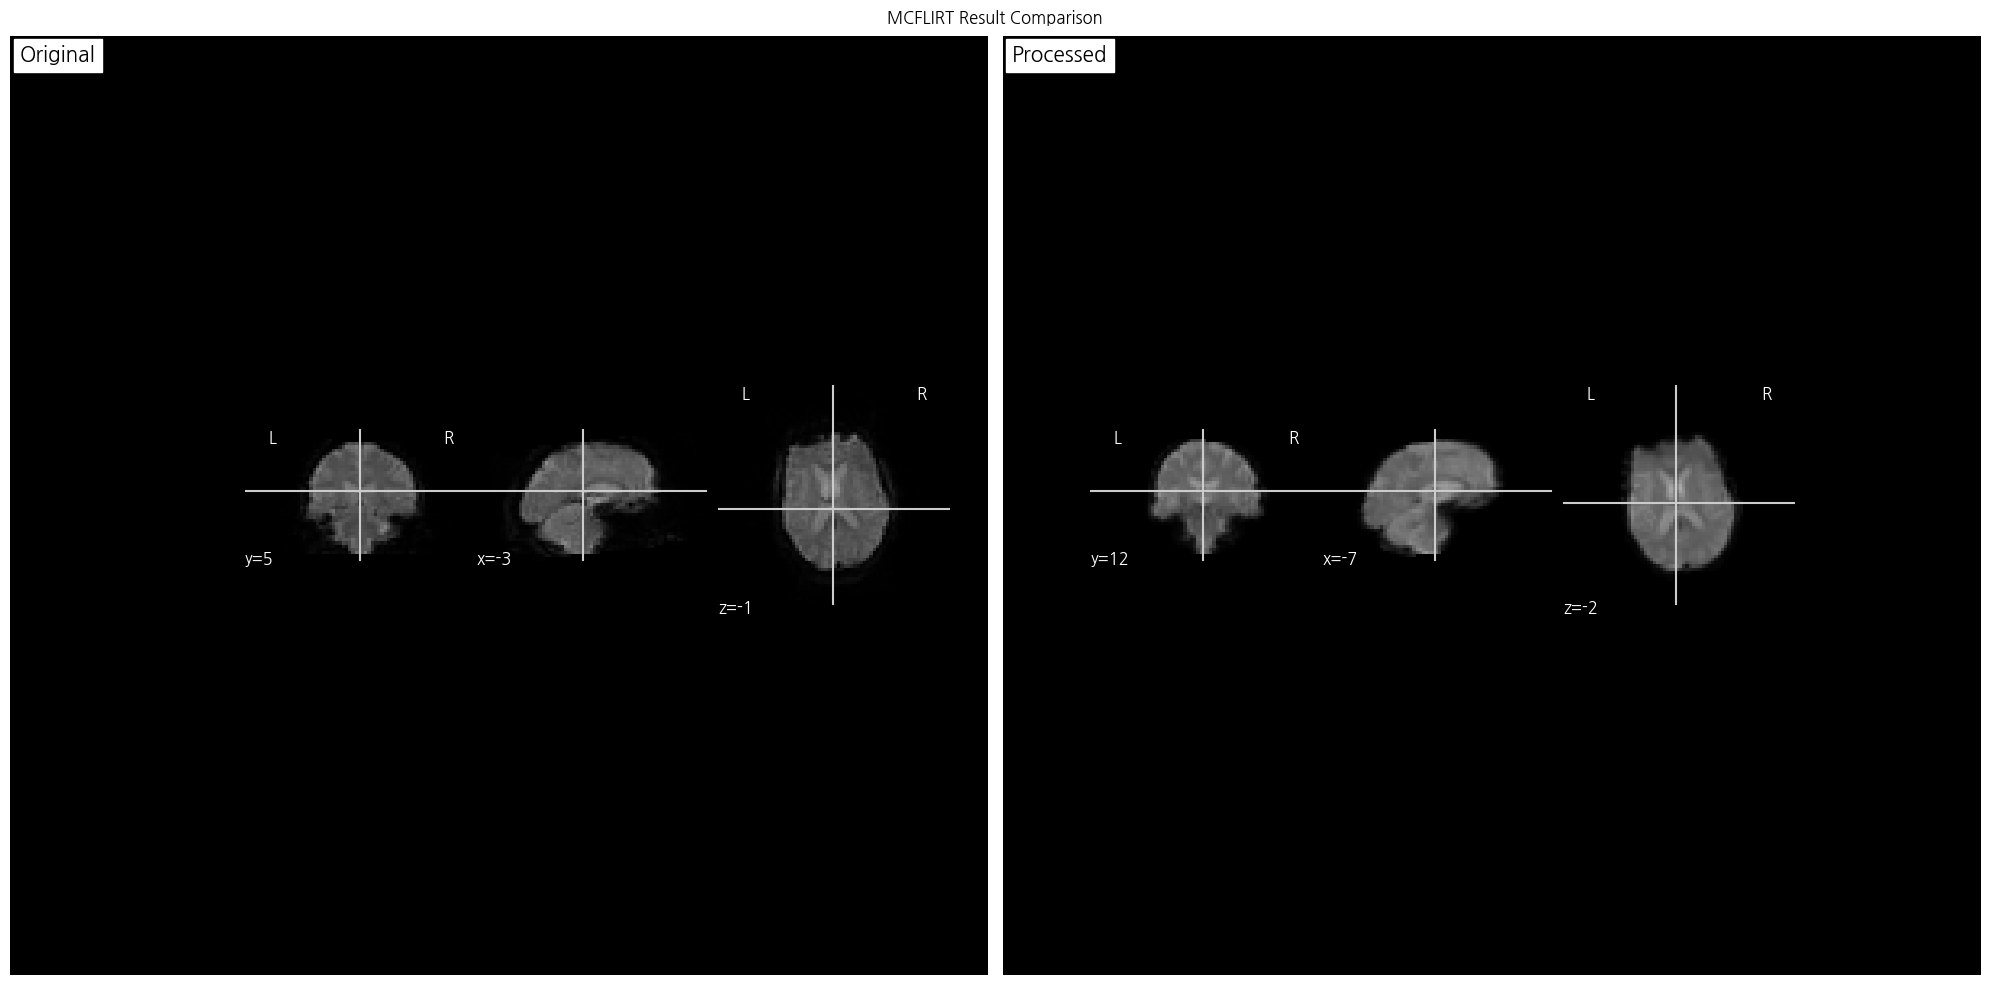

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/tmp/ipykernel_56786/2029235058.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


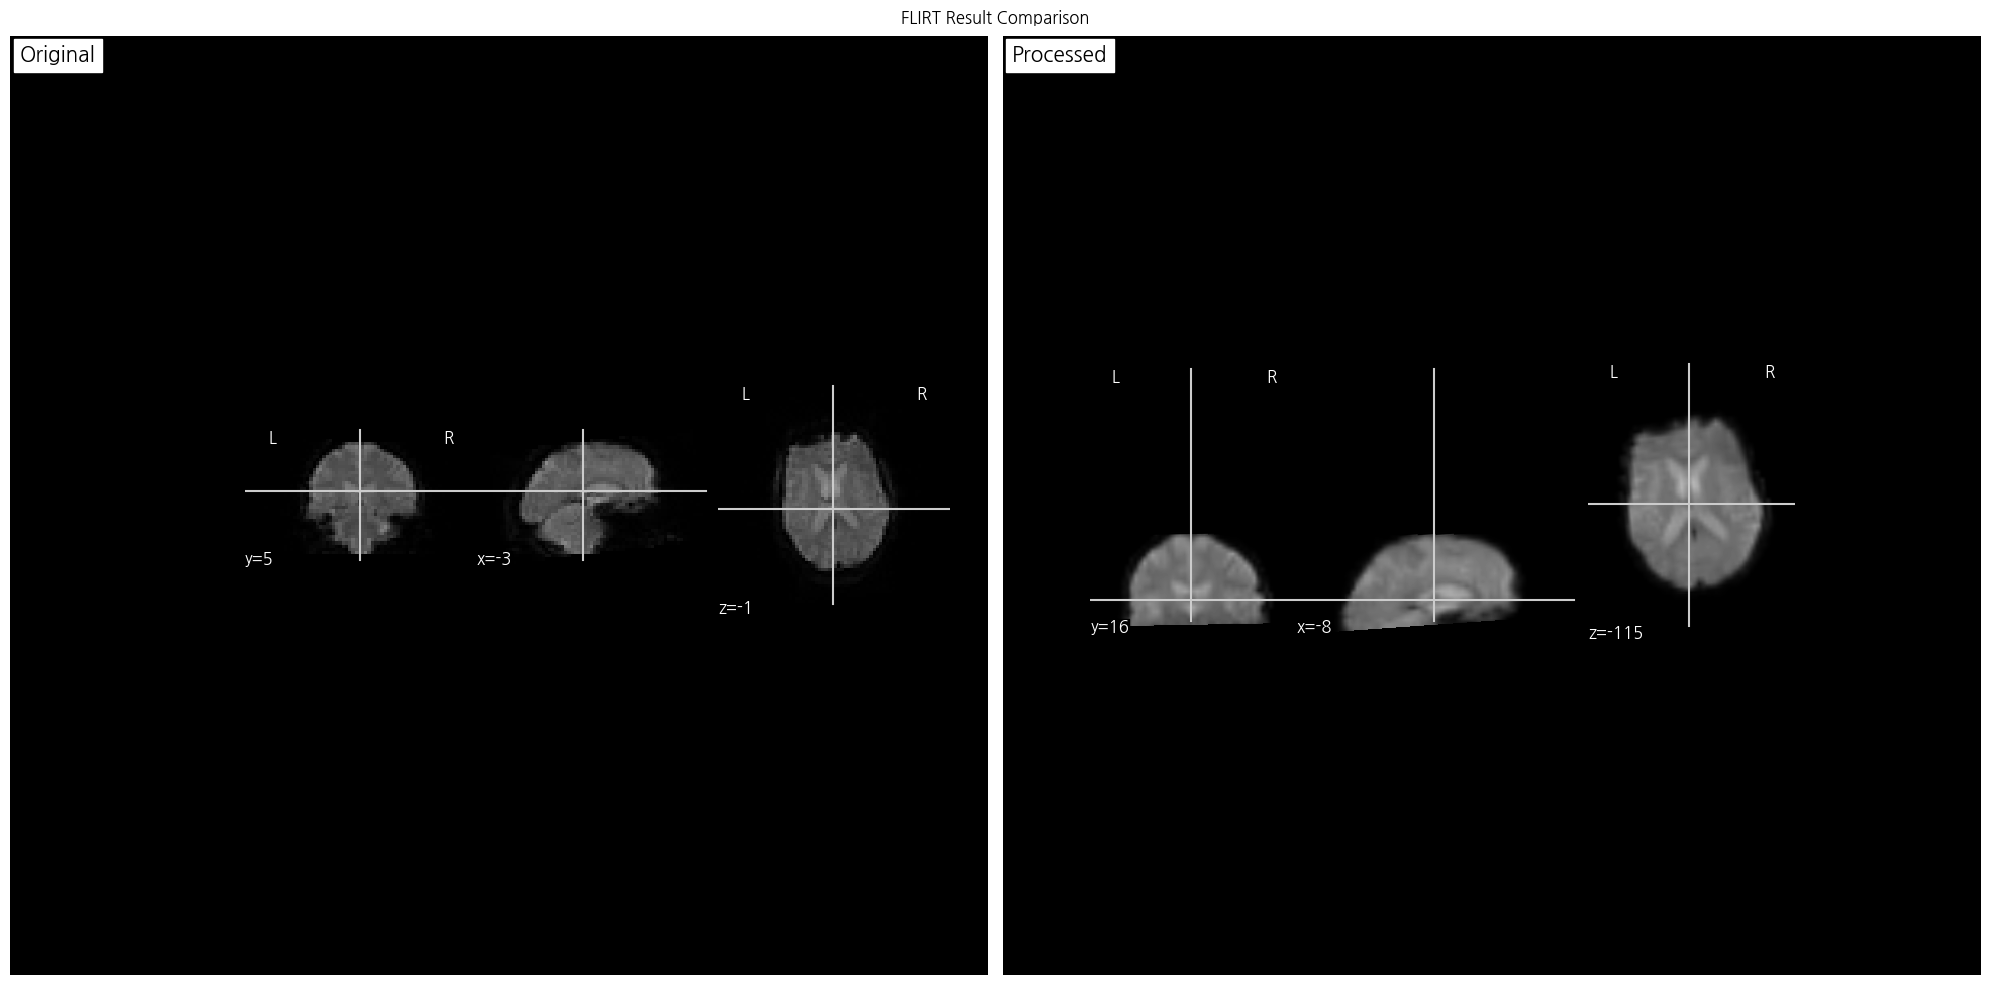

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/tmp/ipykernel_56786/2029235058.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


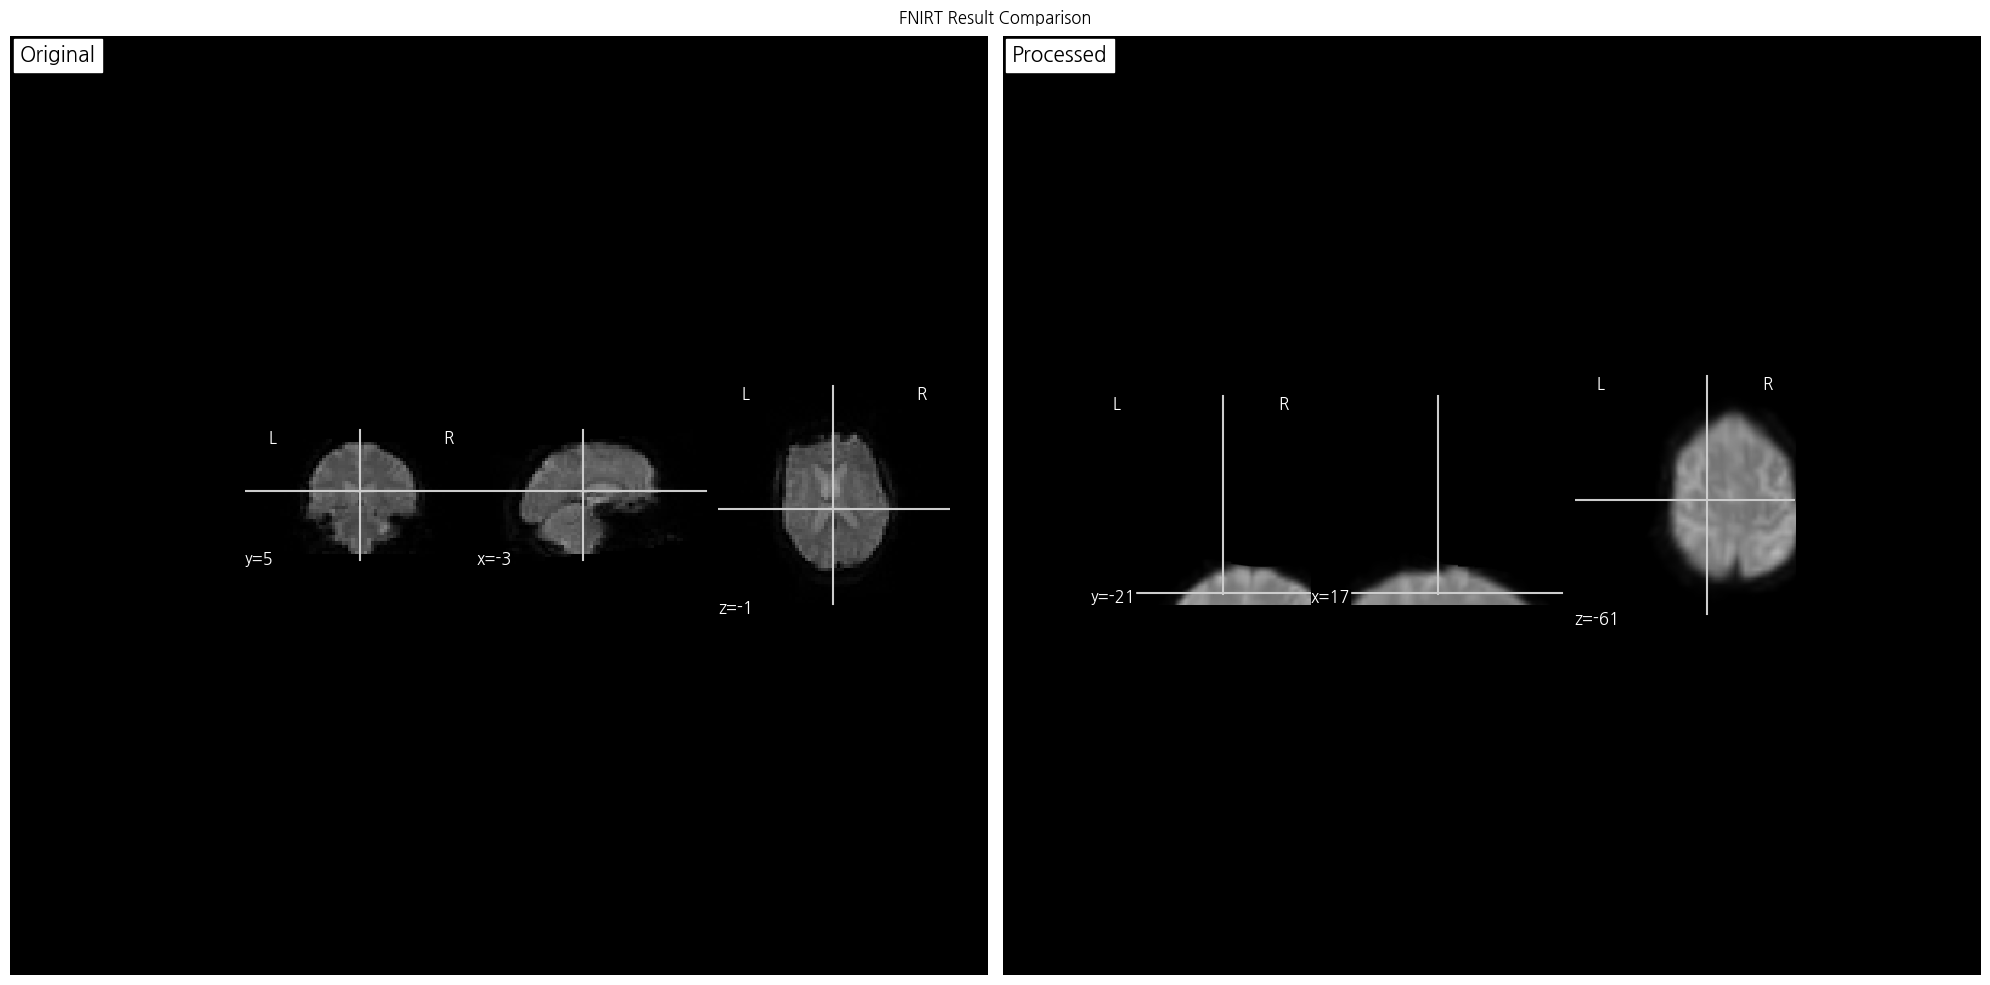

Visualization of preprocessing steps completed.


In [14]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.image import index_img

def compare_images(original_img, processed_img, title, output_dir):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    if len(original_img.shape) == 4:
        original_img = index_img(original_img, 0)
    if len(processed_img.shape) == 4:
        processed_img = index_img(processed_img, 0)
    
    plotting.plot_anat(original_img, title="Original", axes=ax1, display_mode='ortho')
    plotting.plot_anat(processed_img, title="Processed", axes=ax2, display_mode='ortho')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/func2/NIFTI/sub-OAS30064_ses-d0687_task-rest_run-02_bold.nii.gz'
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample2'

original_fmri = nib.load(fmri_file)

bet_output = os.path.join(output_dir, "bet_output.nii.gz")
bet_result = nib.load(bet_output)
compare_images(original_fmri, bet_result, "BET Result Comparison", output_dir)

mcflirt_output = os.path.join(output_dir, "mcflirt_output.nii.gz")
mcflirt_result = nib.load(mcflirt_output)
compare_images(original_fmri, mcflirt_result, "MCFLIRT Result Comparison", output_dir)

flirt_output = os.path.join(output_dir, "func_to_struct.nii.gz")
flirt_result = nib.load(flirt_output)
compare_images(original_fmri, flirt_result, "FLIRT Result Comparison", output_dir)

fnirt_output = os.path.join(output_dir, "func_to_mni.nii.gz")
fnirt_result = nib.load(fnirt_output)
compare_images(original_fmri, fnirt_result, "FNIRT Result Comparison", output_dir)

print("Visualization of preprocessing steps completed.")

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/tmp/ipykernel_56786/3178004360.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


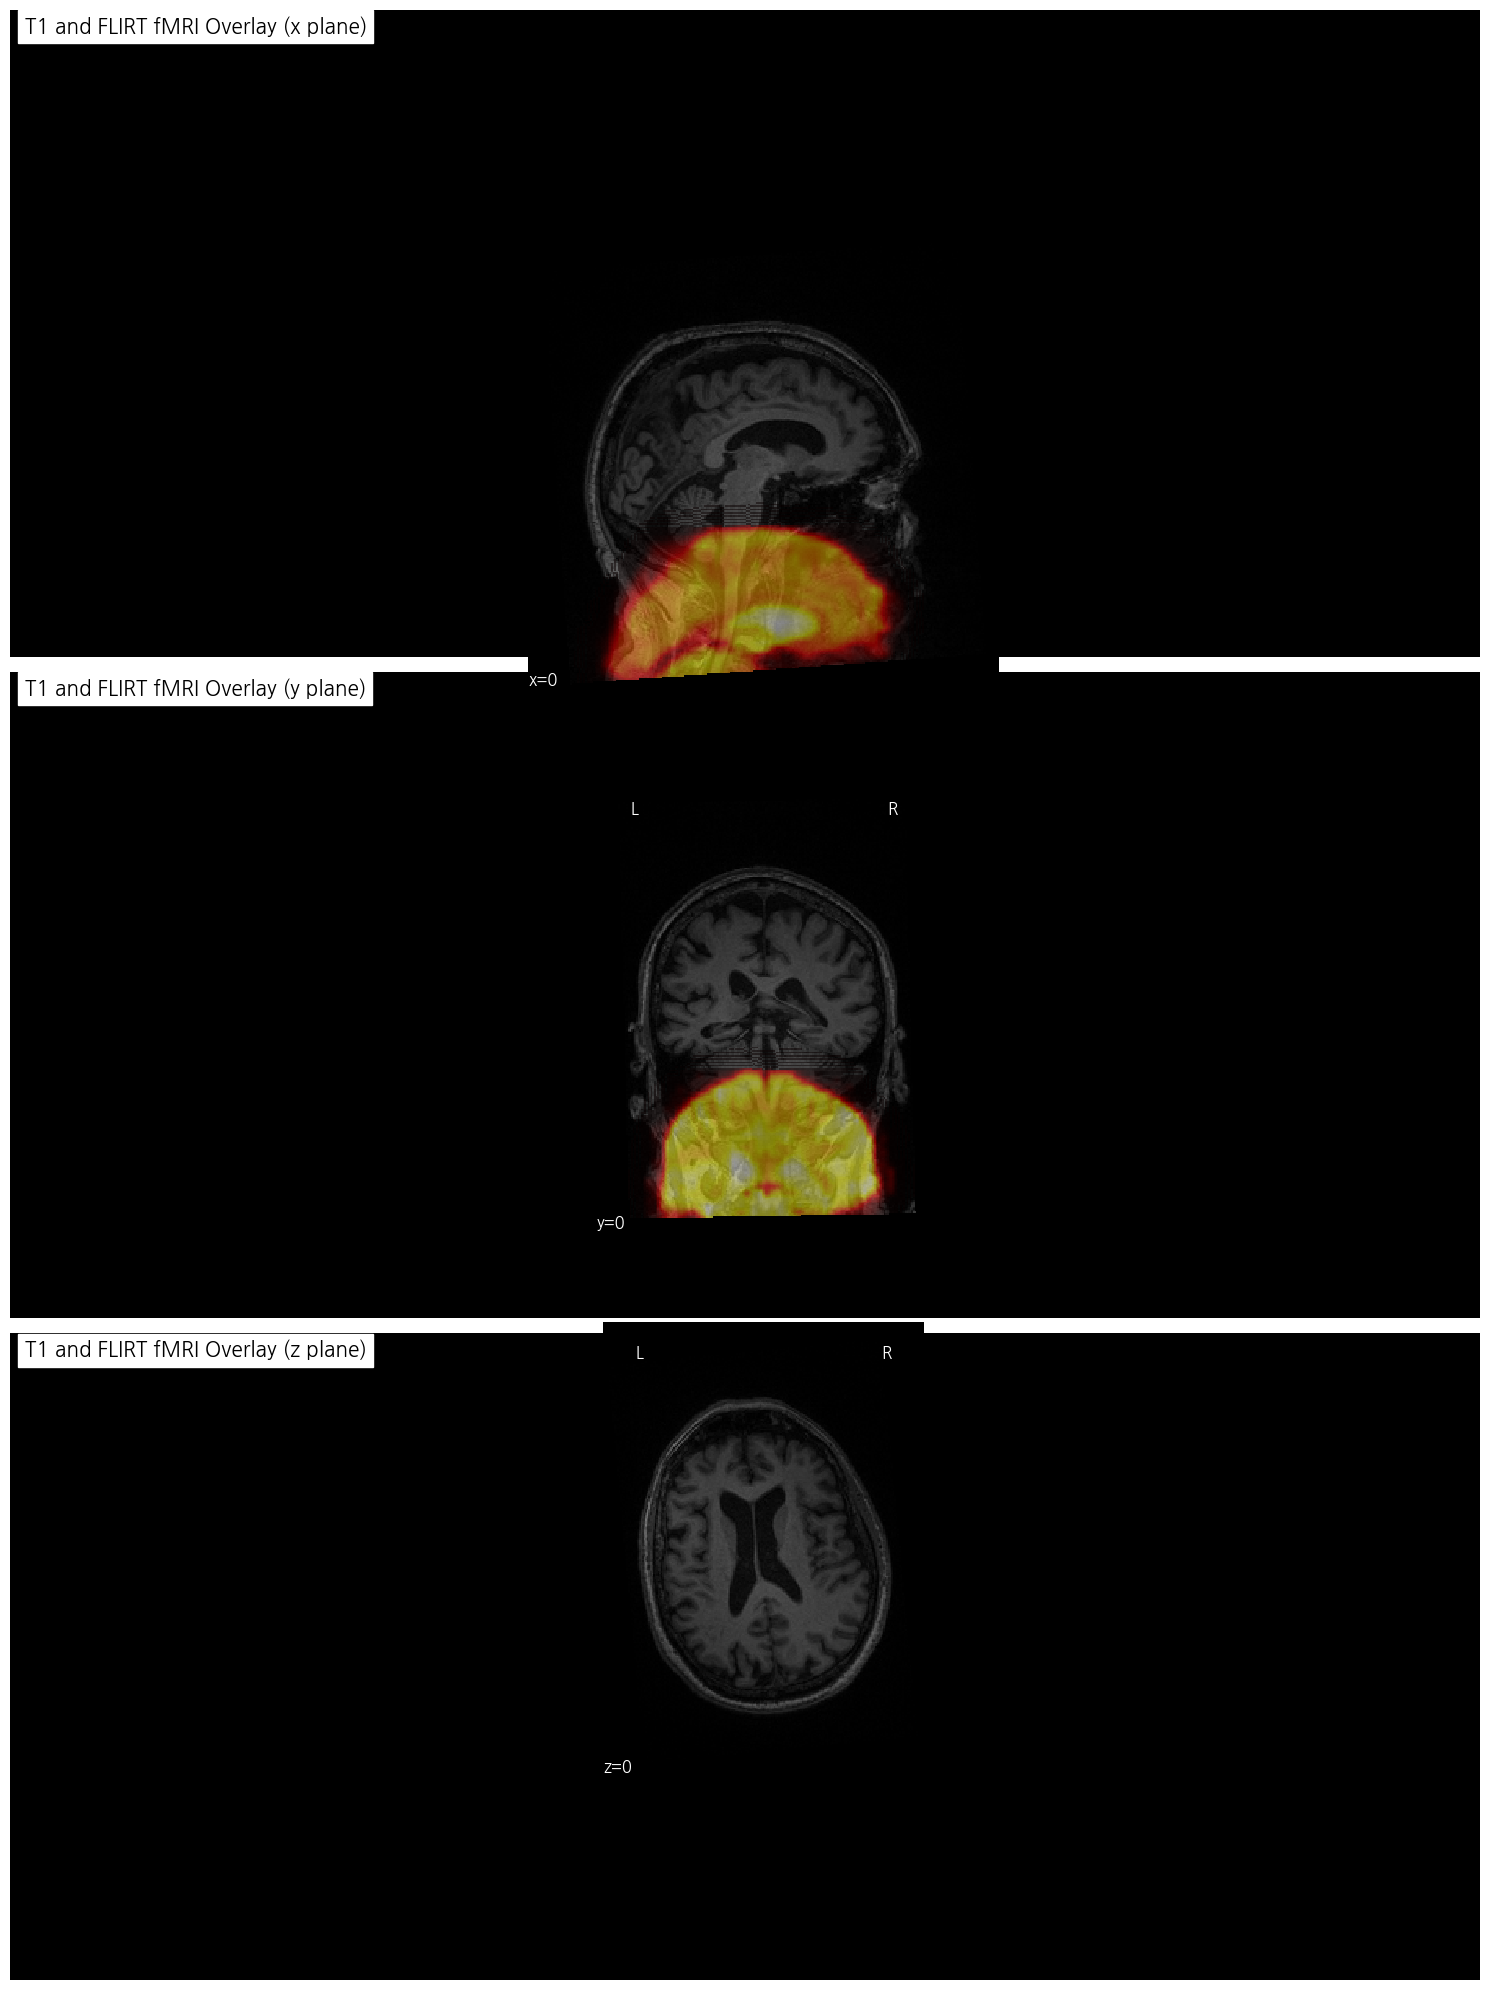

T1 and FLIRT fMRI overlay comparison completed. Results saved in the output directory.


In [15]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.image import index_img, mean_img

def compare_flirt_with_t1(t1_file, flirt_output, output_dir):
    t1_img = nib.load(t1_file)
    flirt_img = nib.load(flirt_output)
    
    if len(flirt_img.shape) == 4:
        flirt_img = mean_img(flirt_img)
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 20))
    
    cut_coords = [0, 0, 0]  
    display_modes = ['x', 'y', 'z']
    
    for i, (mode, ax) in enumerate(zip(display_modes, axes)):
        display = plotting.plot_anat(t1_img, display_mode=mode, cut_coords=[cut_coords[i]], axes=ax, title=f'T1 and FLIRT fMRI Overlay ({mode} plane)')
        display.add_overlay(flirt_img, cmap='hot', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'flirt_t1_overlay_comparison.png'))
    plt.show()

t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/anat2/NIFTI/sub-OAS30064_ses-d0687_run-01_T1w.nii.gz'
flirt_output = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample2/func_to_struct.nii.gz'
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample2'

compare_flirt_with_t1(t1_file, flirt_output, output_dir)

print("T1 and FLIRT fMRI overlay comparison completed. Results saved in the output directory.")

# T1w BET 적용

In [18]:

import os
import subprocess
import nibabel as nib
import numpy as np
import time

os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/func2/NIFTI/sub-OAS30064_ses-d0687_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/anat2/NIFTI/sub-OAS30064_ses-d0687_run-01_T1w.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample3'

os.makedirs(output_dir, exist_ok=True)

print("Starting T1w preprocessing...")
start_time = time.time()
t1_reoriented = os.path.join(output_dir, "t1_reoriented.nii.gz")
reorient_command = f"fslreorient2std {t1_file} {t1_reoriented}"
subprocess.run(reorient_command, shell=True, check=True)

t1_brain = os.path.join(output_dir, "t1_brain")
t1_bet_command = f"bet {t1_reoriented} {t1_brain} -f 0.5 "
subprocess.run(t1_bet_command, shell=True, check=True)
print(f"T1w preprocessing completed in {time.time() - start_time:.2f} seconds")

fmri_img = nib.load(fmri_file)
fmri_data = fmri_img.get_fdata()

print("Starting BET brain extraction for fMRI...")
start_time = time.time()
first_volume = nib.Nifti1Image(fmri_data[..., 0], fmri_img.affine, fmri_img.header)
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_path)

bet_output = os.path.join(output_dir, "bet_output")
bet_command = f"bet {first_volume_path} {bet_output} -F -f 0.5 -m"
subprocess.run(bet_command, shell=True, check=True)
print(f"BET brain extraction completed in {time.time() - start_time:.2f} seconds")

mask_img = nib.load(f"{bet_output}_mask.nii.gz")
mask_data = mask_img.get_fdata()
masked_fmri_data = fmri_data * mask_data[..., np.newaxis]
masked_fmri_img = nib.Nifti1Image(masked_fmri_data, fmri_img.affine, fmri_img.header)
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")
nib.save(masked_fmri_img, masked_fmri_path)

print("Starting MCFLIRT motion correction...")
start_time = time.time()
mcflirt_output = os.path.join(output_dir, "mcflirt_output")
mcflirt_command = f"mcflirt -in {masked_fmri_path} -out {mcflirt_output} -plots"
subprocess.run(mcflirt_command, shell=True, check=True)
print(f"MCFLIRT motion correction completed in {time.time() - start_time:.2f} seconds")

motion_corrected_fmri = f"{mcflirt_output}.nii.gz"

print("Starting FLIRT registration...")
start_time = time.time()

mc_fmri_img = nib.load(motion_corrected_fmri)
mc_first_volume = nib.Nifti1Image(mc_fmri_img.get_fdata()[..., 0], mc_fmri_img.affine, mc_fmri_img.header)
mc_first_volume_path = os.path.join(output_dir, "mc_first_volume.nii.gz")
nib.save(mc_first_volume, mc_first_volume_path)

flirt_mat_output = os.path.join(output_dir, "func_to_struct.mat")
flirt_command = f"flirt -in {mc_first_volume_path} -ref {t1_brain} -omat {flirt_mat_output} -cost corratio -dof 6 -searchrx -90 90 -searchry -90 90 -searchrz -90 90"
subprocess.run(flirt_command, shell=True, check=True)

flirt_output = os.path.join(output_dir, "func_to_struct")
apply_xfm_command = f"applywarp --in={motion_corrected_fmri} --ref={t1_brain} --premat={flirt_mat_output} --out={flirt_output}"
subprocess.run(apply_xfm_command, shell=True, check=True)
print(f"FLIRT registration and application completed in {time.time() - start_time:.2f} seconds")

print("Starting FNIRT registration...")
start_time = time.time()
fnirt_output = os.path.join(output_dir, "func_to_mni")
fnirt_command = f"fnirt --in={t1_brain} --ref={mni_template} --aff={flirt_mat_output} --cout={fnirt_output}_warp"
subprocess.run(fnirt_command, shell=True, check=True)
print(f"FNIRT registration completed in {time.time() - start_time:.2f} seconds")

print("Applying warp to fMRI data...")
start_time = time.time()
apply_warp_command = f"applywarp --in={flirt_output} --ref={mni_template} --warp={fnirt_output}_warp --out={fnirt_output}"
subprocess.run(apply_warp_command, shell=True, check=True)
print(f"Warp application completed in {time.time() - start_time:.2f} seconds")

print("fMRI preprocessing pipeline completed successfully.")

Starting T1w preprocessing...
T1w preprocessing completed in 3.73 seconds
Starting BET brain extraction for fMRI...
BET brain extraction completed in 0.98 seconds
Starting MCFLIRT motion correction...
MCFLIRT motion correction completed in 16.86 seconds
Starting FLIRT registration...
FLIRT registration and application completed in 685.66 seconds
Starting FNIRT registration...
FNIRT registration completed in 382.89 seconds
Applying warp to fMRI data...
Warp application completed in 417.59 seconds
fMRI preprocessing pipeline completed successfully.


In [19]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.image import index_img, mean_img

def visualize_result(original_img, processed_img, title, output_dir):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    if len(original_img.shape) == 4:
        original_img = index_img(original_img, 0)
    if len(processed_img.shape) == 4:
        processed_img = mean_img(processed_img)
    
    plotting.plot_anat(original_img, title="Original", axes=ax1, display_mode='ortho')
    plotting.plot_anat(processed_img, title="Processed", axes=ax2, display_mode='ortho')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{title.replace(' ', '_')}.png"))
    plt.close()

# 파일 경로 설정
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample3'
fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/func2/NIFTI/sub-OAS30064_ses-d0687_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/anat2/NIFTI/sub-OAS30064_ses-d0687_run-01_T1w.nii.gz'

# 원본 이미지 로드
original_t1 = nib.load(t1_file)
original_fmri = nib.load(fmri_file)

# T1w BET 결과 시각화
t1_brain = nib.load(os.path.join(output_dir, "t1_brain.nii.gz"))
visualize_result(original_t1, t1_brain, "T1w Brain Extraction", output_dir)

# fMRI BET 결과 시각화
bet_output = nib.load(os.path.join(output_dir, "bet_output.nii.gz"))
visualize_result(original_fmri, bet_output, "fMRI Brain Extraction", output_dir)

# MCFLIRT 결과 시각화
mcflirt_output = nib.load(os.path.join(output_dir, "mcflirt_output.nii.gz"))
visualize_result(original_fmri, mcflirt_output, "Motion Correction", output_dir)

# FLIRT 결과 시각화
flirt_output = nib.load(os.path.join(output_dir, "func_to_struct.nii.gz"))
visualize_result(original_fmri, flirt_output, "Functional to Structural Registration", output_dir)

# FNIRT 결과 시각화
fnirt_output = nib.load(os.path.join(output_dir, "func_to_mni.nii.gz"))
visualize_result(original_fmri, fnirt_output, "Non-linear Registration to MNI space", output_dir)

print("Visualization completed. Results saved in the output directory.")

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/tmp/ipykernel_56786/1633390780.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/tmp/ipykernel_56786/1633390780.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/tmp/ipykernel_56786/1633390780.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results mig

Visualization completed. Results saved in the output directory.


/tmp/ipykernel_56786/1633390780.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/tmp/ipykernel_56786/2713447093.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


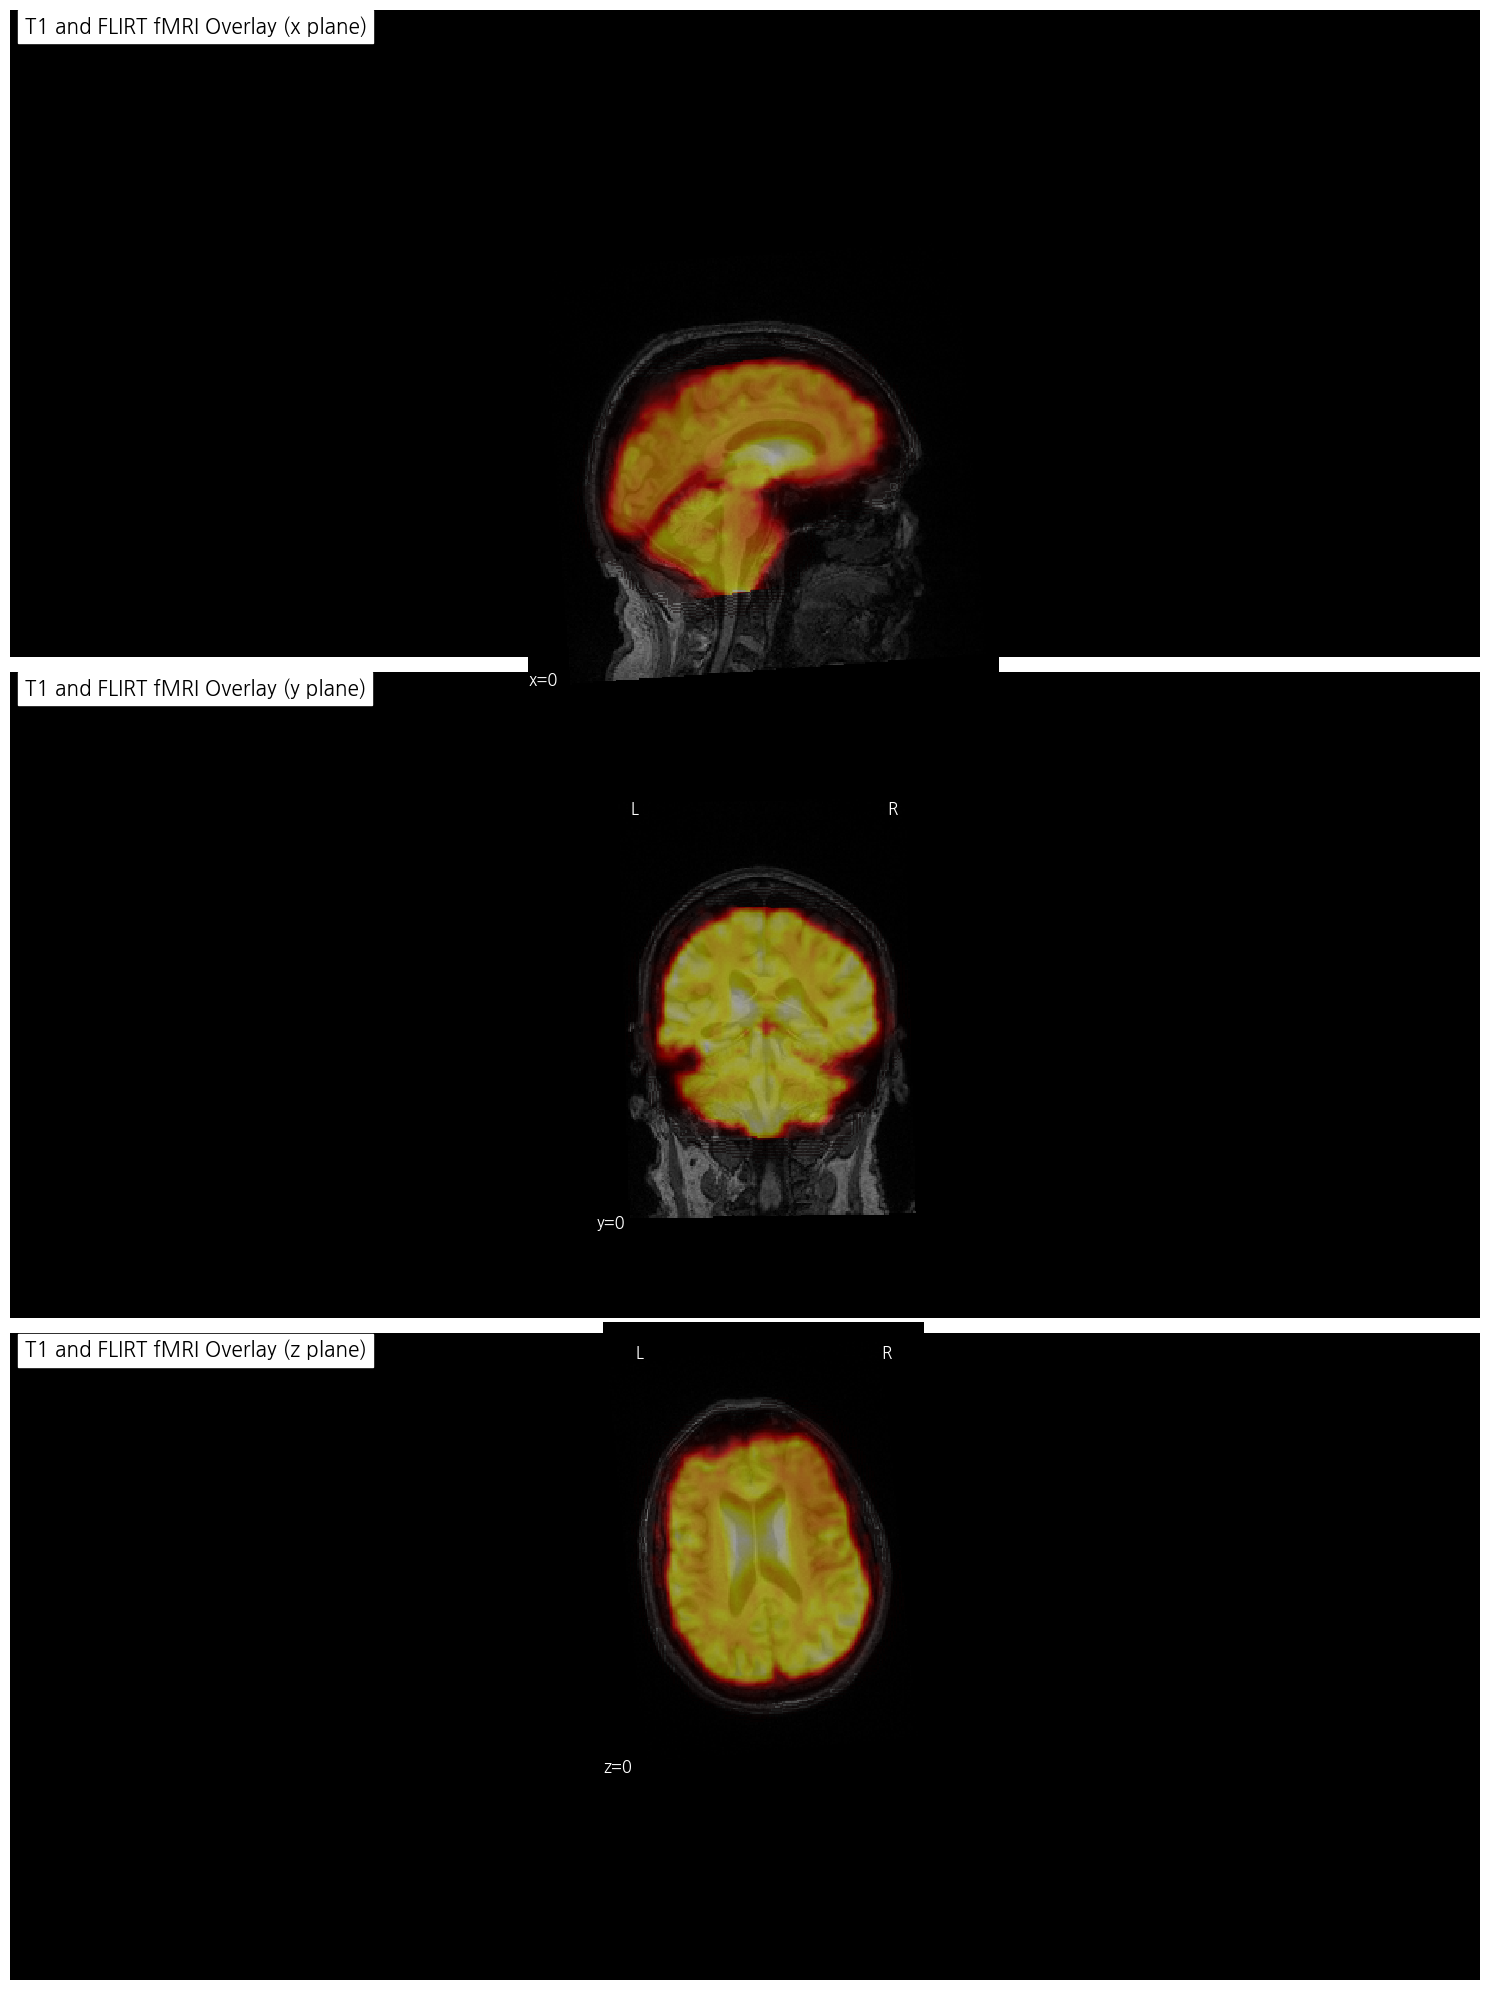

T1 and FLIRT fMRI overlay comparison completed. Results saved in the output directory.


In [20]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.image import index_img, mean_img

def compare_flirt_with_t1(t1_file, flirt_output, output_dir):
    t1_img = nib.load(t1_file)
    flirt_img = nib.load(flirt_output)
    
    if len(flirt_img.shape) == 4:
        flirt_img = mean_img(flirt_img)
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 20))
    
    cut_coords = [0, 0, 0] 
    display_modes = ['x', 'y', 'z']
    
    for i, (mode, ax) in enumerate(zip(display_modes, axes)):
        display = plotting.plot_anat(t1_img, display_mode=mode, cut_coords=[cut_coords[i]], axes=ax, title=f'T1 and FLIRT fMRI Overlay ({mode} plane)')
        display.add_overlay(flirt_img, cmap='hot', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'flirt_t1_overlay_comparison.png'))
    plt.show()

t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/anat2/NIFTI/sub-OAS30064_ses-d0687_run-01_T1w.nii.gz'
flirt_output = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample3/func_to_struct.nii.gz'
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample3'

compare_flirt_with_t1(t1_file, flirt_output, output_dir)

print("T1 and FLIRT fMRI overlay comparison completed. Results saved in the output directory.")

# Aug4

In [22]:
import os
import subprocess
import nibabel as nib
import numpy as np
import time

os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/func2/NIFTI/sub-OAS30064_ses-d0687_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/anat2/NIFTI/sub-OAS30064_ses-d0687_run-01_T1w.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample3'

os.makedirs(output_dir, exist_ok=True)

# T1w preprocessing
print("Starting T1w preprocessing...")
start_time = time.time()
t1_reoriented = os.path.join(output_dir, "t1_reoriented.nii.gz")
reorient_command = f"fslreorient2std {t1_file} {t1_reoriented}"
subprocess.run(reorient_command, shell=True, check=True)

t1_brain = os.path.join(output_dir, "t1_brain")
t1_bet_command = f"bet {t1_reoriented} {t1_brain} -f 0.5"  # Removed -R option
subprocess.run(t1_bet_command, shell=True, check=True)
print(f"T1w preprocessing completed in {time.time() - start_time:.2f} seconds")

# fMRI preprocessing
print("Starting fMRI preprocessing...")
start_time = time.time()
fmri_img = nib.load(fmri_file)
fmri_data = fmri_img.get_fdata()

# BET on first volume
first_volume = nib.Nifti1Image(fmri_data[..., 0], fmri_img.affine, fmri_img.header)
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_path)

bet_output = os.path.join(output_dir, "bet_output")
bet_command = f"bet {first_volume_path} {bet_output} -F -f 0.5 -m"
subprocess.run(bet_command, shell=True, check=True)

# Apply BET mask to all volumes
mask_img = nib.load(f"{bet_output}_mask.nii.gz")
mask_data = mask_img.get_fdata()
masked_fmri_data = fmri_data * mask_data[..., np.newaxis]
masked_fmri_img = nib.Nifti1Image(masked_fmri_data, fmri_img.affine, fmri_img.header)
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")
nib.save(masked_fmri_img, masked_fmri_path)

# MCFLIRT
print("Starting MCFLIRT motion correction...")
mcflirt_output = os.path.join(output_dir, "mcflirt_output")
mcflirt_command = f"mcflirt -in {masked_fmri_path} -out {mcflirt_output} -plots"
subprocess.run(mcflirt_command, shell=True, check=True)
motion_corrected_fmri = f"{mcflirt_output}.nii.gz"
print(f"MCFLIRT motion correction completed")

print(f"fMRI preprocessing completed in {time.time() - start_time:.2f} seconds")

# T1w to MNI registration (FNIRT)
print("Starting T1w to MNI registration (FNIRT)...")
start_time = time.time()
fnirt_output = os.path.join(output_dir, "t1_to_mni")
fnirt_command = f"fnirt --in={t1_brain} --ref={mni_template} --cout={fnirt_output}_warp"
subprocess.run(fnirt_command, shell=True, check=True)
print(f"T1w to MNI registration completed in {time.time() - start_time:.2f} seconds")

# fMRI to T1w registration (FLIRT)
print("Starting fMRI to T1w registration (FLIRT)...")
start_time = time.time()
mc_fmri_img = nib.load(motion_corrected_fmri)
mc_first_volume = nib.Nifti1Image(mc_fmri_img.get_fdata()[..., 0], mc_fmri_img.affine, mc_fmri_img.header)
mc_first_volume_path = os.path.join(output_dir, "mc_first_volume.nii.gz")
nib.save(mc_first_volume, mc_first_volume_path)

flirt_mat_output = os.path.join(output_dir, "func_to_struct.mat")
flirt_command = f"flirt -in {mc_first_volume_path} -ref {t1_brain} -omat {flirt_mat_output} -cost corratio -dof 6 -searchrx -90 90 -searchry -90 90 -searchrz -90 90"
subprocess.run(flirt_command, shell=True, check=True)
print(f"fMRI to T1w registration completed in {time.time() - start_time:.2f} seconds")

# Combine transformations and apply to fMRI
print("Combining transformations and applying to fMRI...")
start_time = time.time()
combined_warp = os.path.join(output_dir, "combined_warp.nii.gz")
combine_warps_command = f"convertwarp --ref={mni_template} --premat={flirt_mat_output} --warp1={fnirt_output}_warp --out={combined_warp}"
subprocess.run(combine_warps_command, shell=True, check=True)

final_output = os.path.join(output_dir, "fmri_in_mni_space")
apply_warp_command = f"applywarp --in={motion_corrected_fmri} --ref={mni_template} --warp={combined_warp} --out={final_output}"
subprocess.run(apply_warp_command, shell=True, check=True)
print(f"Combined transformation and application completed in {time.time() - start_time:.2f} seconds")

print("fMRI preprocessing pipeline completed successfully.")

Starting T1w preprocessing...
T1w preprocessing completed in 3.96 seconds
Starting fMRI preprocessing...
Starting MCFLIRT motion correction...
MCFLIRT motion correction completed
fMRI preprocessing completed in 18.91 seconds
Starting T1w to MNI registration (FNIRT)...
T1w to MNI registration completed in 479.74 seconds
Starting fMRI to T1w registration (FLIRT)...
fMRI to T1w registration completed in 3.73 seconds
Combining transformations and applying to fMRI...
Combined transformation and application completed in 22757.69 seconds
fMRI preprocessing pipeline completed successfully.


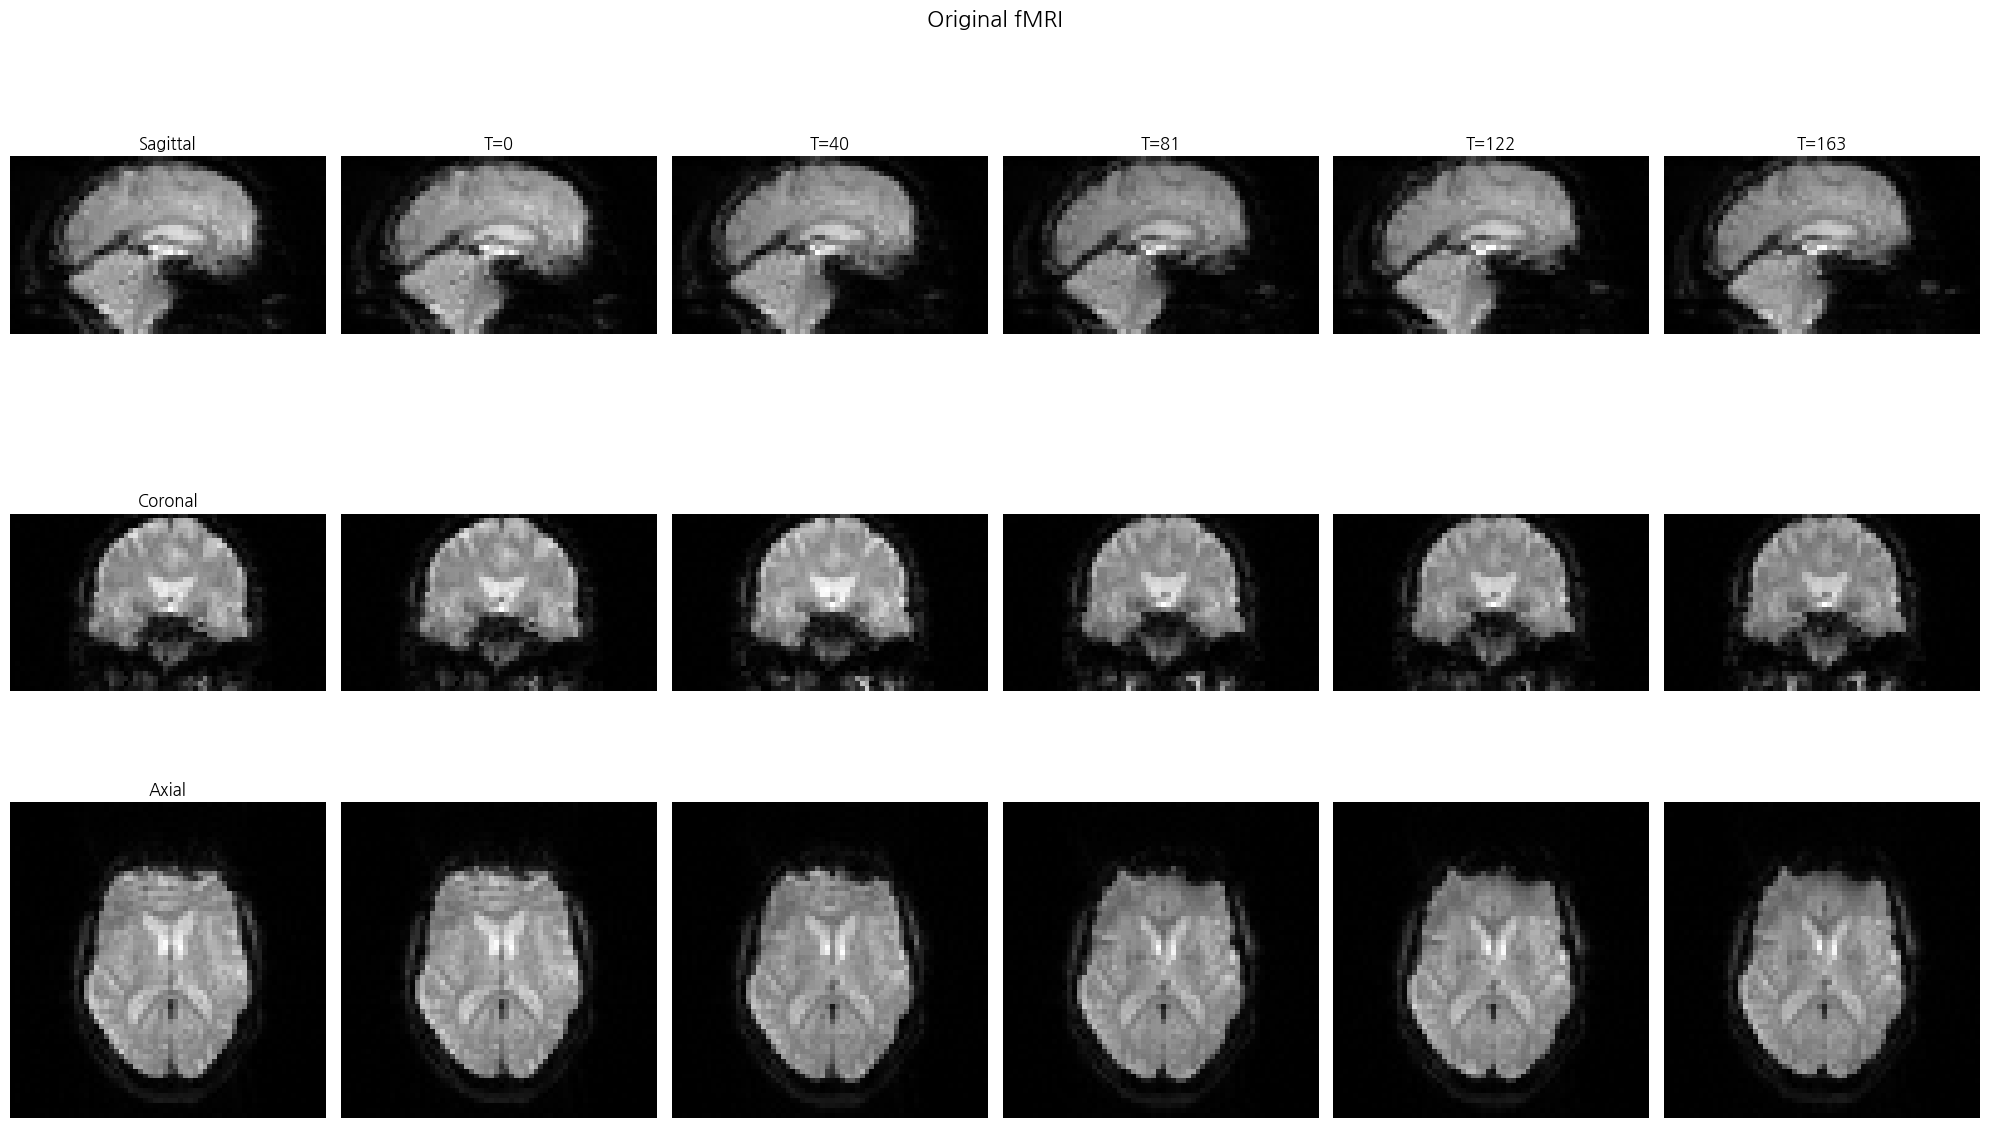

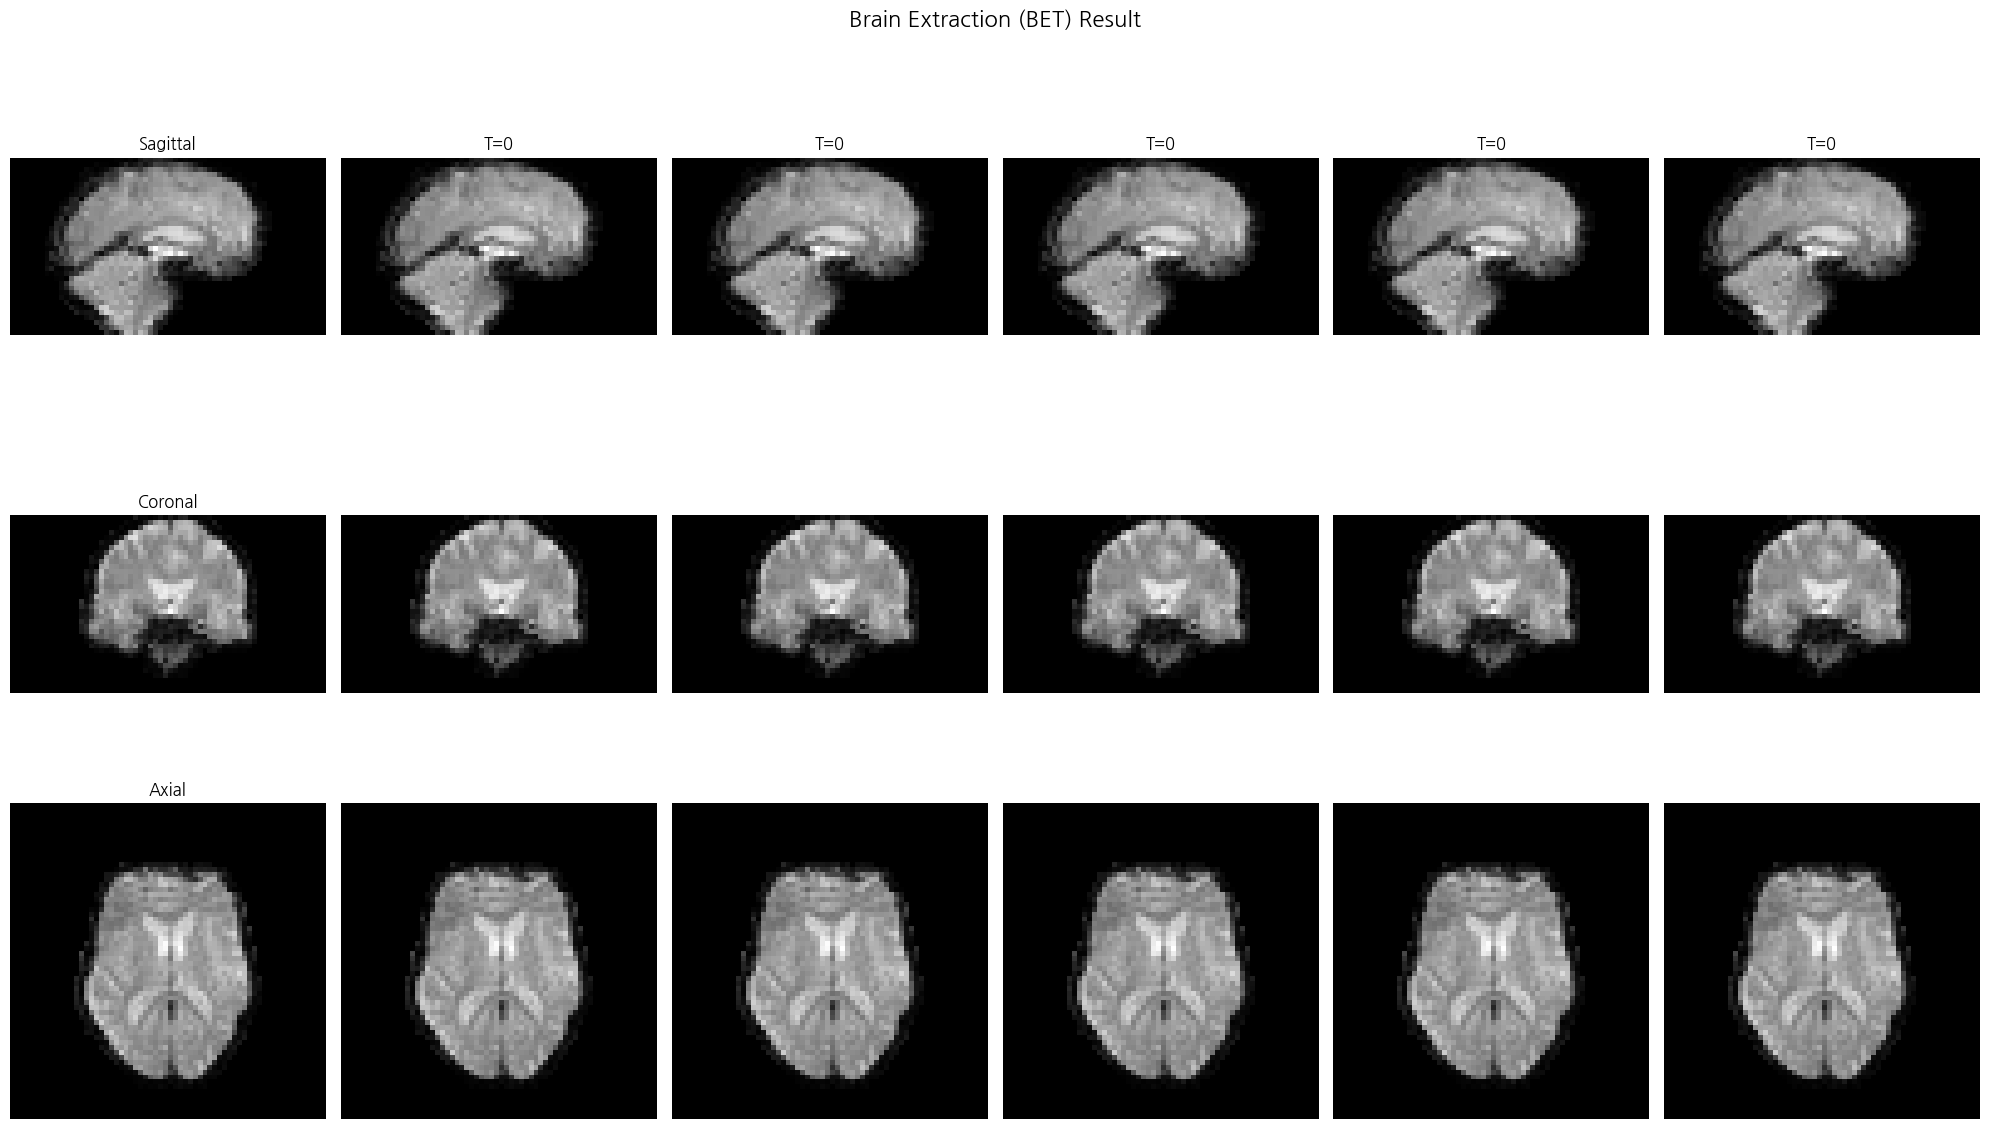

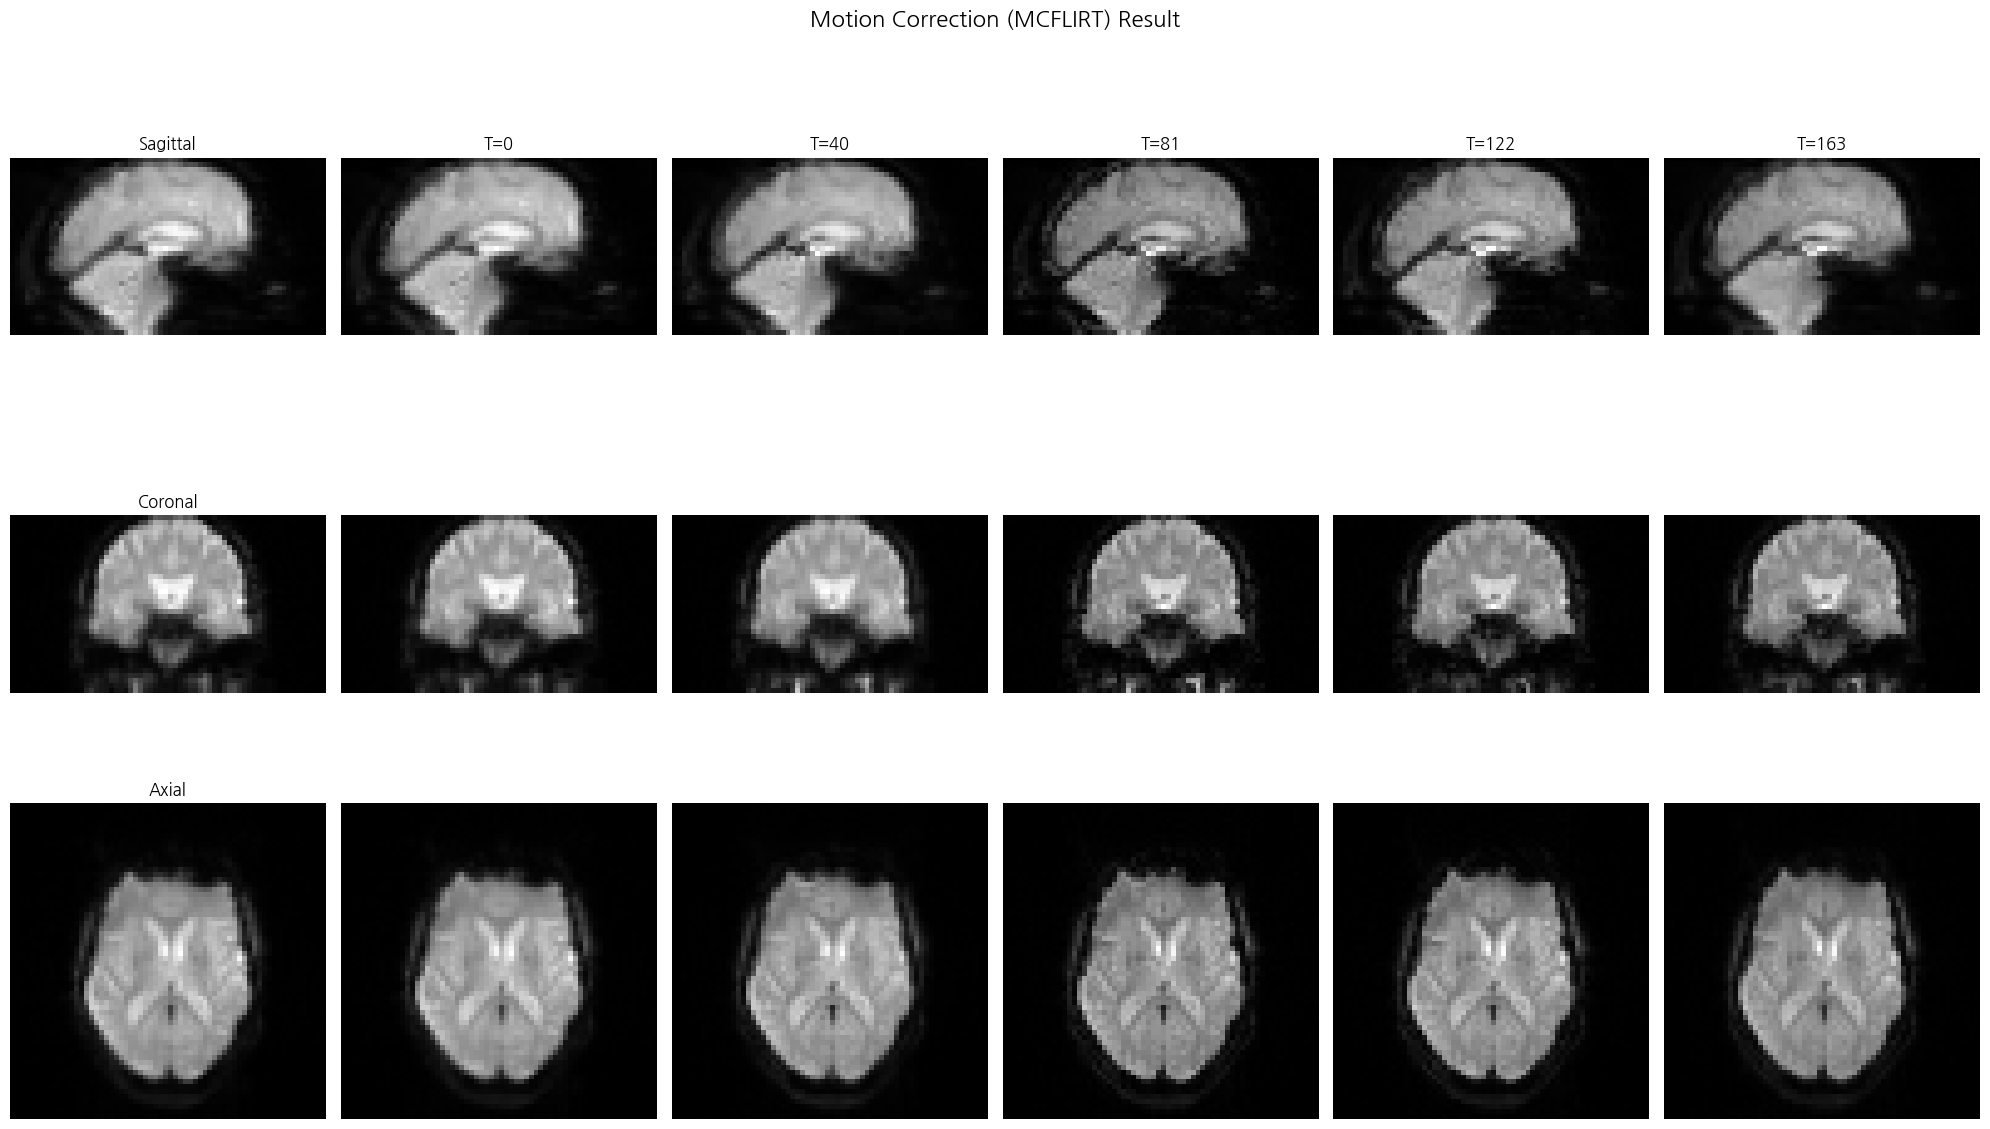

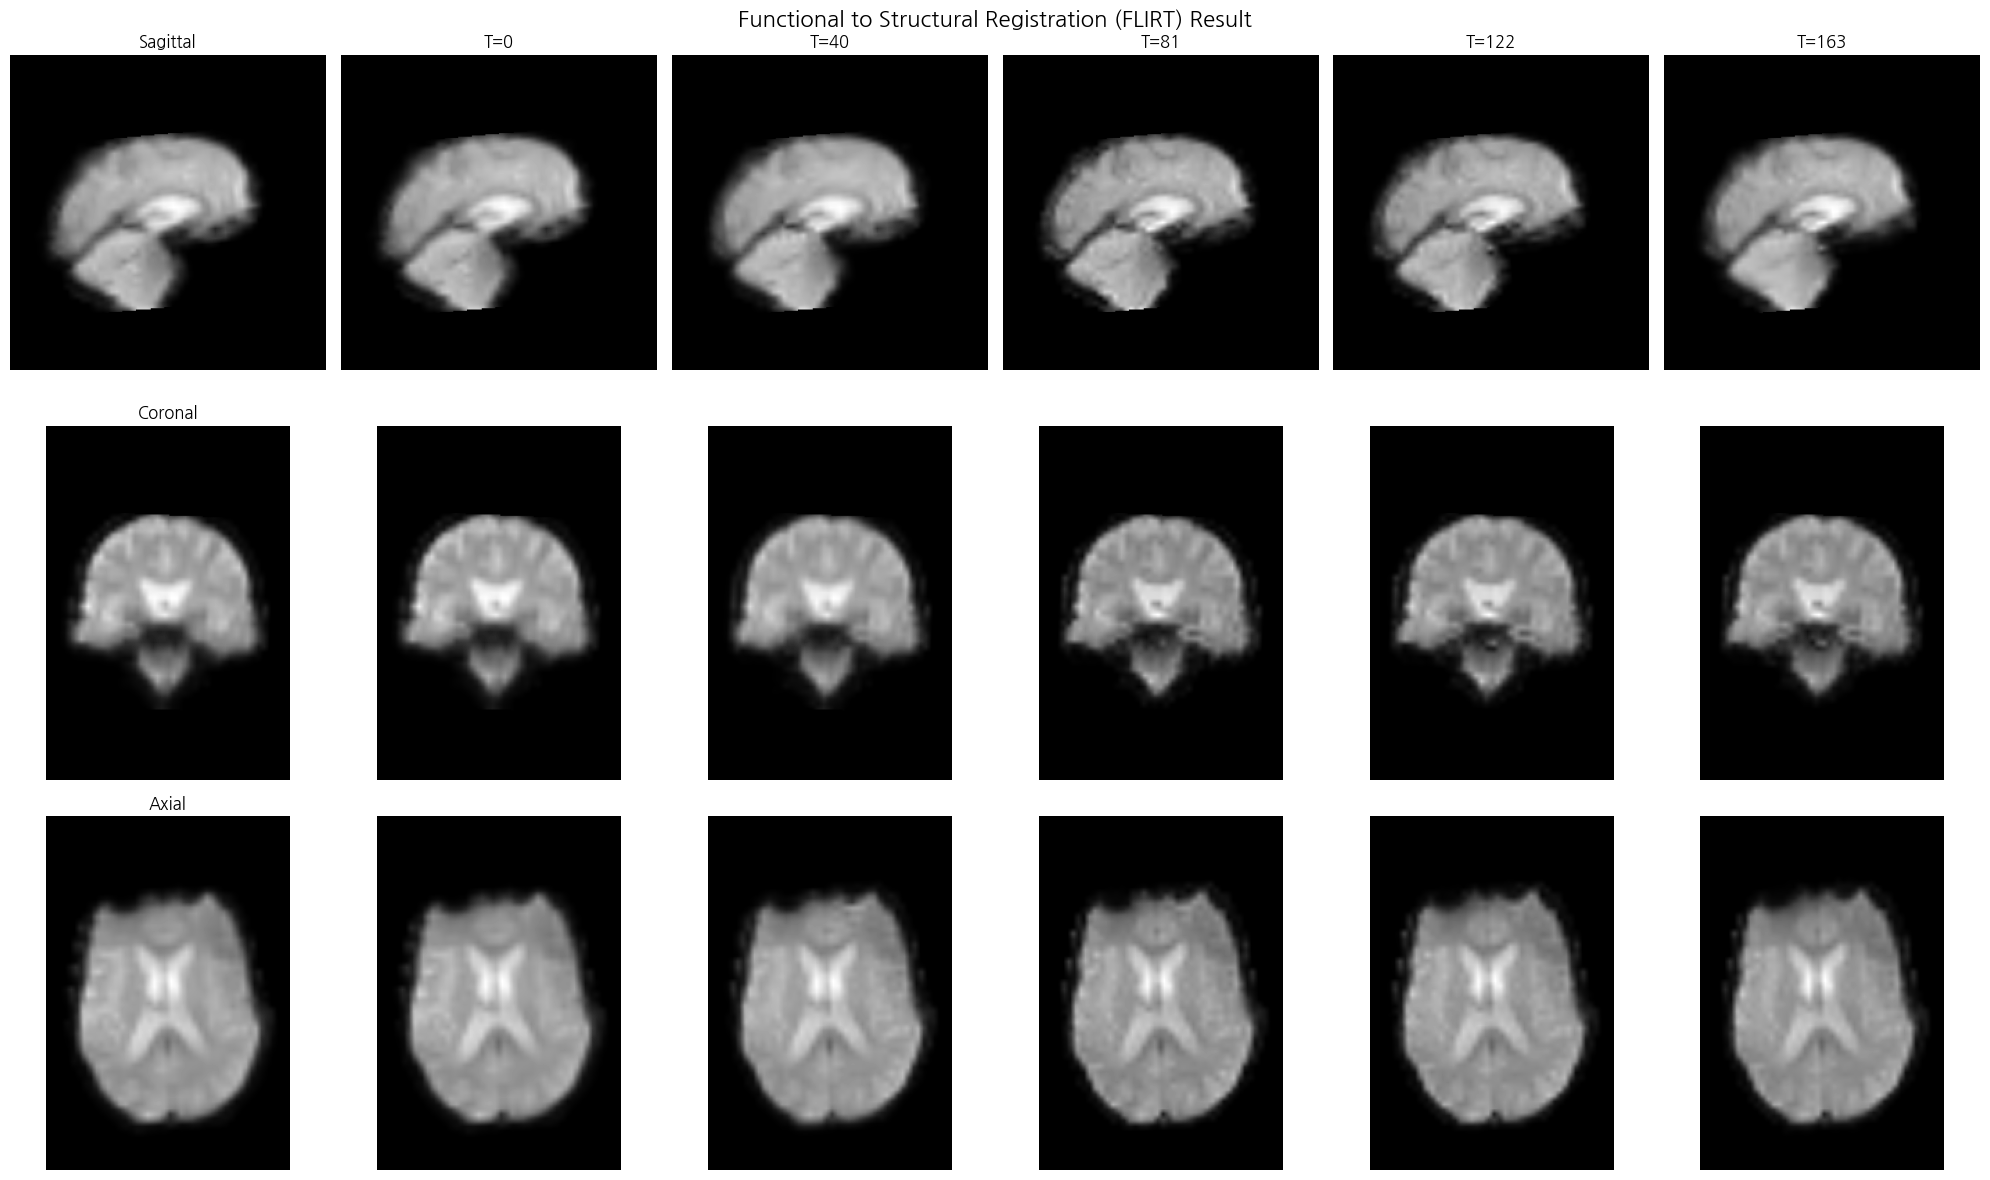

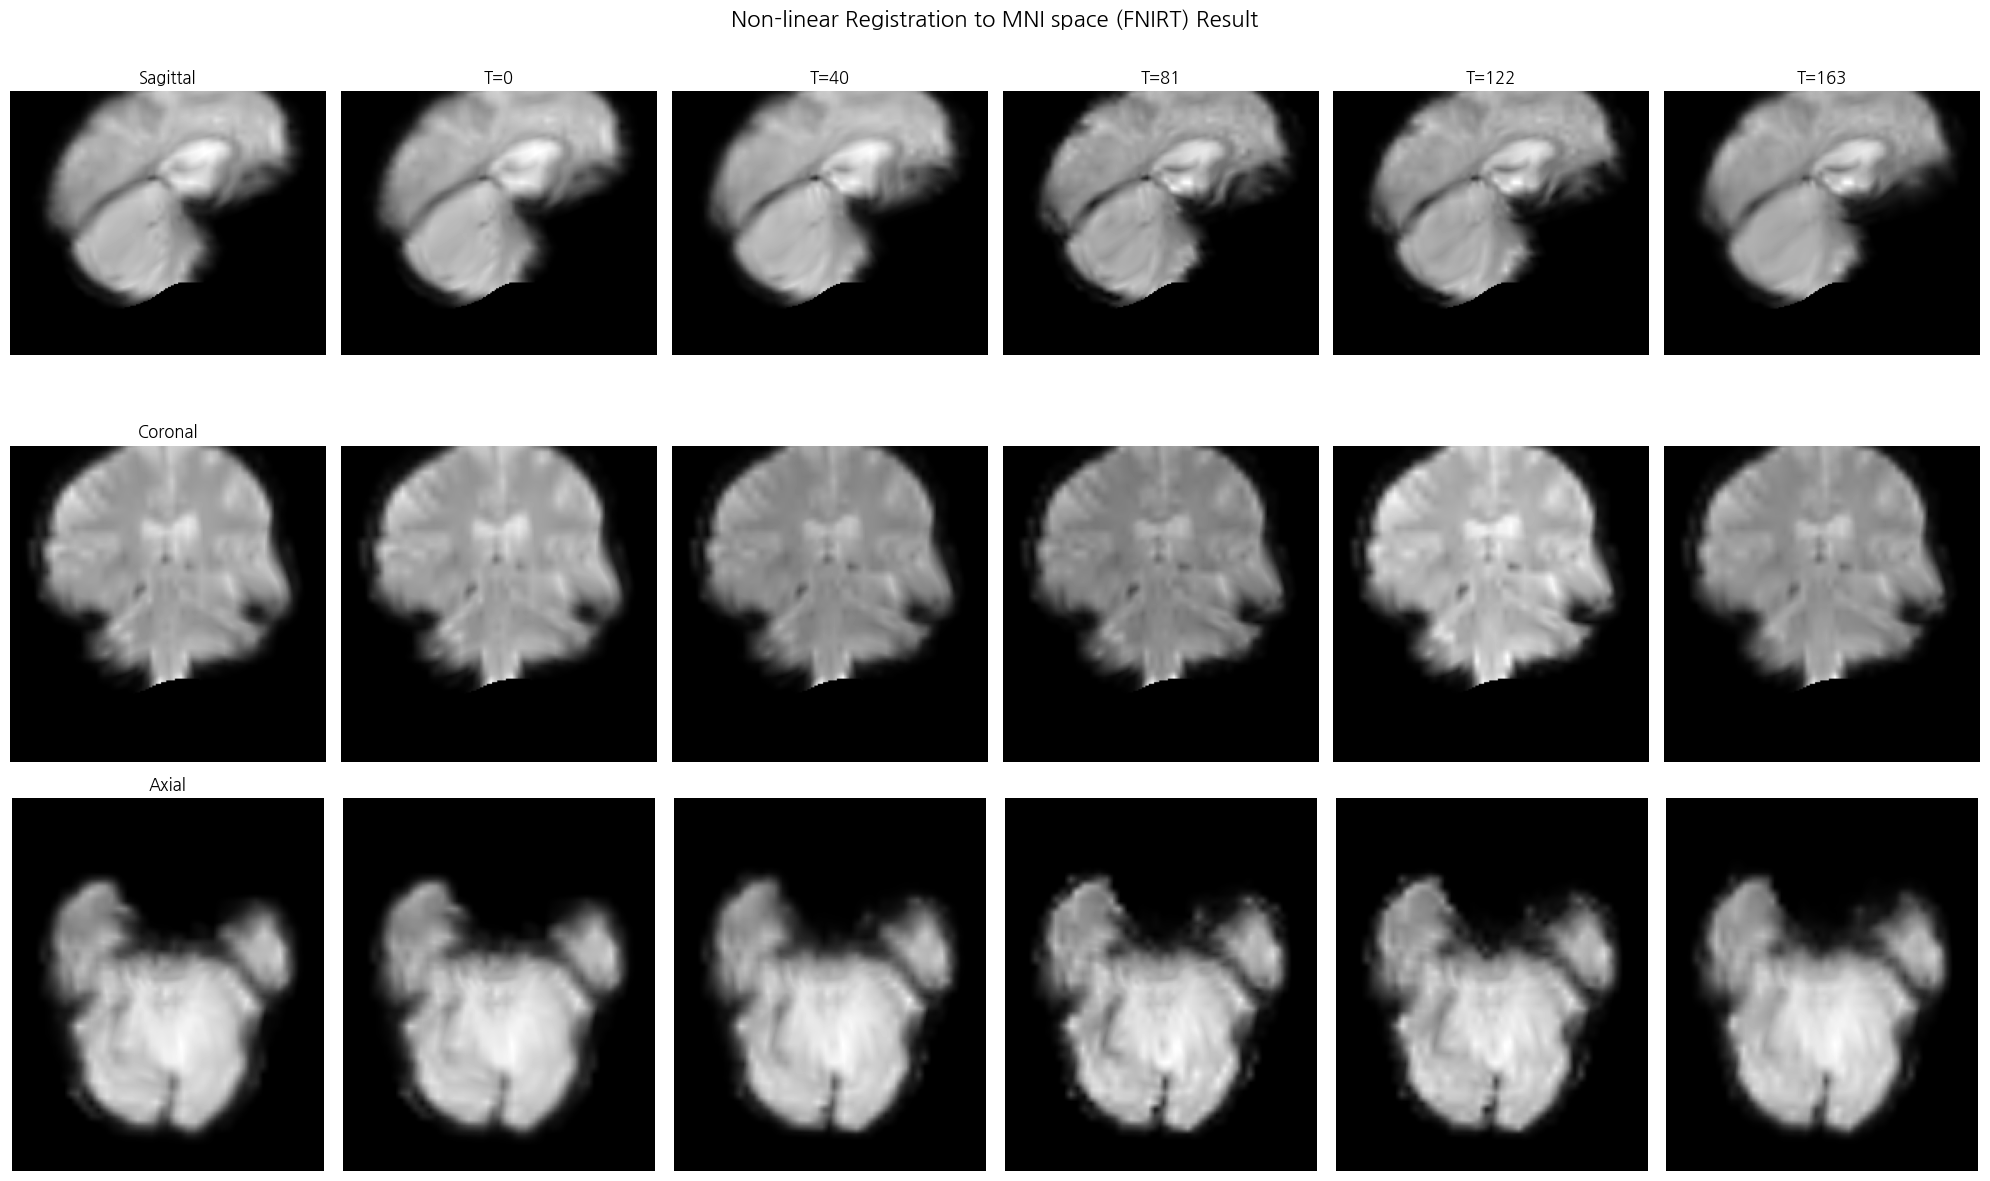

Visualization completed.


In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def visualize_fmri_result(img, title, n_timepoints=5):
    data = img.get_fdata()
    if len(data.shape) == 3:
        data = data[..., np.newaxis]
    
    fig, axes = plt.subplots(3, n_timepoints + 1, figsize=(20, 12))
    fig.suptitle(title, fontsize=16)
    
    # Get middle slices for each dimension
    mid_x, mid_y, mid_z = [s // 2 for s in data.shape[:3]]
    
    time_points = np.linspace(0, data.shape[3] - 1, n_timepoints).astype(int)
    
    # Plot middle slices
    axes[0, 0].imshow(np.rot90(data[mid_x, :, :, 0]), cmap='gray')
    axes[0, 0].set_title('Sagittal')
    axes[1, 0].imshow(np.rot90(data[:, mid_y, :, 0]), cmap='gray')
    axes[1, 0].set_title('Coronal')
    axes[2, 0].imshow(np.rot90(data[:, :, mid_z, 0]), cmap='gray')
    axes[2, 0].set_title('Axial')
    
    # Plot time series
    for i, t in enumerate(time_points):
        axes[0, i+1].imshow(np.rot90(data[mid_x, :, :, t]), cmap='gray')
        axes[0, i+1].set_title(f'T={t}')
        axes[1, i+1].imshow(np.rot90(data[:, mid_y, :, t]), cmap='gray')
        axes[2, i+1].imshow(np.rot90(data[:, :, mid_z, t]), cmap='gray')
    
    for ax in axes.ravel():
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# 파일 경로 설정
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample3'
fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/func2/NIFTI/sub-OAS30064_ses-d0687_task-rest_run-02_bold.nii.gz'

# 결과 이미지 로드
original_fmri = nib.load(fmri_file)
bet_output = nib.load(os.path.join(output_dir, "bet_output.nii.gz"))
mcflirt_output = nib.load(os.path.join(output_dir, "mcflirt_output.nii.gz"))
flirt_output = nib.load(os.path.join(output_dir, "func_to_struct.nii.gz"))
fnirt_output = nib.load(os.path.join(output_dir, "fmri_in_mni_space.nii.gz"))

# 결과 시각화
visualize_fmri_result(original_fmri, "Original fMRI")
visualize_fmri_result(bet_output, "Brain Extraction (BET) Result")
visualize_fmri_result(mcflirt_output, "Motion Correction (MCFLIRT) Result")
visualize_fmri_result(flirt_output, "Functional to Structural Registration (FLIRT) Result")
visualize_fmri_result(fnirt_output, "Non-linear Registration to MNI space (FNIRT) Result")

print("Visualization completed.")

# MC -> BET 

In [8]:
import os
import subprocess
import nibabel as nib
import numpy as np
import time

os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/func2/NIFTI/sub-OAS30064_ses-d0687_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/anat2/NIFTI/sub-OAS30064_ses-d0687_run-01_T1w.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample5'

os.makedirs(output_dir, exist_ok=True)

print("Starting T1w preprocessing...")
start_time = time.time()
t1_reoriented = os.path.join(output_dir, "t1_reoriented.nii.gz")
reorient_command = f"fslreorient2std {t1_file} {t1_reoriented}"
subprocess.run(reorient_command, shell=True, check=True)

t1_brain = os.path.join(output_dir, "t1_brain")
t1_bet_command = f"bet {t1_reoriented} {t1_brain} -f 0.5"
subprocess.run(t1_bet_command, shell=True, check=True)
print(f"T1w preprocessing completed in {time.time() - start_time:.2f} seconds")

print("Starting fMRI preprocessing...")
start_time = time.time()

print("Starting MCFLIRT motion correction...")
mcflirt_output = os.path.join(output_dir, "mcflirt_output")
mcflirt_command = f"mcflirt -in {fmri_file} -out {mcflirt_output} -plots"
subprocess.run(mcflirt_command, shell=True, check=True)
motion_corrected_fmri = f"{mcflirt_output}.nii.gz"
print(f"MCFLIRT motion correction completed")

mc_fmri_img = nib.load(motion_corrected_fmri)
first_volume = nib.Nifti1Image(mc_fmri_img.get_fdata()[..., 0], mc_fmri_img.affine, mc_fmri_img.header)
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_path)

bet_output = os.path.join(output_dir, "bet_output")
bet_command = f"bet {first_volume_path} {bet_output} -F -f 0.5 -m"
subprocess.run(bet_command, shell=True, check=True)

mask_img = nib.load(f"{bet_output}_mask.nii.gz")
mask_data = mask_img.get_fdata()
mc_fmri_data = mc_fmri_img.get_fdata()
masked_fmri_data = mc_fmri_data * mask_data[..., np.newaxis]
masked_fmri_img = nib.Nifti1Image(masked_fmri_data, mc_fmri_img.affine, mc_fmri_img.header)
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")
nib.save(masked_fmri_img, masked_fmri_path)

print(f"fMRI preprocessing completed in {time.time() - start_time:.2f} seconds")

print("Starting T1w to MNI registration (FNIRT)...")
start_time = time.time()
fnirt_output = os.path.join(output_dir, "t1_to_mni")
fnirt_command = f"fnirt --in={t1_brain} --ref={mni_template} --cout={fnirt_output}_warp"
subprocess.run(fnirt_command, shell=True, check=True)
print(f"T1w to MNI registration completed in {time.time() - start_time:.2f} seconds")

print("Starting fMRI to T1w registration (FLIRT)...")
start_time = time.time()
mc_first_volume_path = os.path.join(output_dir, "mc_first_volume.nii.gz")
nib.save(first_volume, mc_first_volume_path)

flirt_mat_output = os.path.join(output_dir, "func_to_struct.mat")
flirt_command = f"flirt -in {mc_first_volume_path} -ref {t1_brain} -omat {flirt_mat_output} -cost corratio -dof 12"
subprocess.run(flirt_command, shell=True, check=True)
print(f"fMRI to T1w registration completed in {time.time() - start_time:.2f} seconds")

print("Combining transformations and applying to fMRI...")
start_time = time.time()
combined_warp = os.path.join(output_dir, "combined_warp.nii.gz")
combine_warps_command = f"convertwarp --ref={mni_template} --premat={flirt_mat_output} --warp1={fnirt_output}_warp --out={combined_warp}" # --warp1: T1w에서 MNI로의 비선형 warp field
subprocess.run(combine_warps_command, shell=True, check=True)

final_output = os.path.join(output_dir, "fmri_in_mni_space")
apply_warp_command = f"applywarp --in={masked_fmri_path} --ref={mni_template} --warp={combined_warp} --out={final_output}"
subprocess.run(apply_warp_command, shell=True, check=True)
print(f"Combined transformation and application completed in {time.time() - start_time:.2f} seconds")

print("fMRI preprocessing pipeline completed successfully.")

Starting T1w preprocessing...
T1w preprocessing completed in 3.18 seconds
Starting fMRI preprocessing...
Starting MCFLIRT motion correction...
MCFLIRT motion correction completed
fMRI preprocessing completed in 20.23 seconds
Starting T1w to MNI registration (FNIRT)...
T1w to MNI registration completed in 490.92 seconds
Starting fMRI to T1w registration (FLIRT)...
fMRI to T1w registration completed in 4.44 seconds
Combining transformations and applying to fMRI...
Combined transformation and application completed in 435.52 seconds
fMRI preprocessing pipeline completed successfully.


시각화가 완료되었습니다. 결과 이미지가 output_dir에 저장되었습니다.


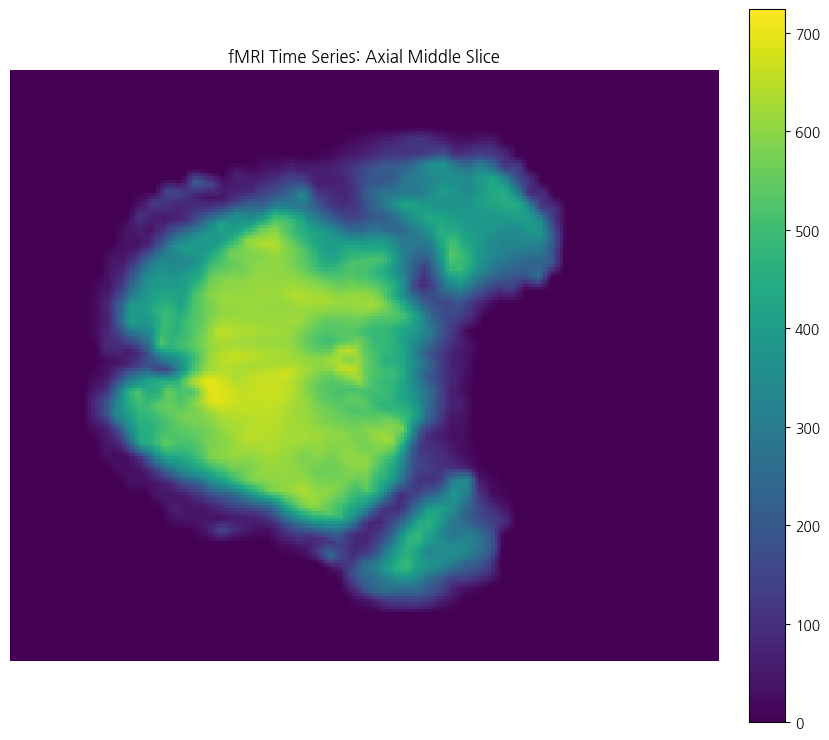

In [9]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image

output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample5'
fmri_in_mni = os.path.join(output_dir, "fmri_in_mni_space.nii.gz")

fmri_img = nib.load(fmri_in_mni)
fmri_data = fmri_img.get_fdata()

time_points = [0, fmri_data.shape[-1] // 2, -1]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("fMRI in MNI Space: Multiple Views and Time Points", fontsize=16)

views = ['Sagittal', 'Coronal', 'Axial']
indices = {'Sagittal': [60, 80, 100], 'Coronal': [60, 80, 100], 'Axial': [30, 40, 50]}

for row, view in enumerate(views):
    for col, time_point in enumerate(time_points):
        if view == 'Sagittal':
            slice_data = np.rot90(fmri_data[indices[view][1], :, :, time_point])
        elif view == 'Coronal':
            slice_data = np.rot90(fmri_data[:, indices[view][1], :, time_point])
        else:  # Axial
            slice_data = np.rot90(fmri_data[:, :, indices[view][1], time_point])
        
        im = axes[row, col].imshow(slice_data, cmap='viridis')
        axes[row, col].set_title(f'{view}: Time {time_point}')
        axes[row, col].axis('off')
        fig.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fmri_multiple_views_timepoints.png'))
plt.close()

for i, time_point in enumerate(time_points):
    fig = plt.figure(figsize=(10, 10))
    plotting.plot_glass_brain(image.index_img(fmri_img, time_point), display_mode='ortho', colorbar=True, figure=fig)
    plt.title(f"3D Glass Brain View of fMRI in MNI Space (Time: {time_point})")
    plt.savefig(os.path.join(output_dir, f'fmri_glass_brain_time{time_point}.png'))
    plt.close()

n_timepoints = fmri_data.shape[-1]
mid_slice = fmri_data.shape[2] // 2

fig, ax = plt.subplots(figsize=(10, 10))
plt.title("fMRI Time Series: Axial Middle Slice")

im = ax.imshow(fmri_data[:, :, mid_slice, 0], cmap='viridis', animated=True)
ax.axis('off')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

def update(frame):
    im.set_array(fmri_data[:, :, mid_slice, frame])
    return [im]

from matplotlib.animation import FuncAnimation
anim = FuncAnimation(fig, update, frames=n_timepoints, interval=50, blit=True)
anim.save(os.path.join(output_dir, 'fmri_time_series.gif'), writer='pillow')

print("시각화가 완료되었습니다. 결과 이미지가 output_dir에 저장되었습니다.")

In [10]:

output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample5'
fmri_in_mni = os.path.join(output_dir, "fmri_in_mni_space.nii.gz")
t1_brain = os.path.join(output_dir, "t1_brain.nii.gz")

fmri_img = nib.load(fmri_in_mni)
fmri_data = fmri_img.get_fdata()

t1_brain_img = nib.load(t1_brain)

time_points = [0, fmri_data.shape[-1] // 2, -1]

# T1w에 fMRI 오버레이
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle("fMRI overlaid on T1w at different time points", fontsize=16)

views = ['x', 'y', 'z']
view_titles = ['Sagittal', 'Coronal', 'Axial']

for i, time_point in enumerate(time_points):
    fmri_timepoint = nib.Nifti1Image(fmri_data[..., time_point], fmri_img.affine, fmri_img.header)
    threshold = np.percentile(fmri_data[..., time_point], 95)


    for j, (view, title) in enumerate(zip(views, view_titles)):
        display = plotting.plot_anat(t1_brain_img, display_mode=view, cut_coords=1, figure=fig, axes=axes[i, j])
        display.add_overlay(fmri_timepoint, cmap='hot', threshold=threshold, colorbar=True)
        axes[i, j].set_title(f"{title}, Time point: {time_point}")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fmri_t1w_overlay_timepoints_multiview.png'))
plt.close()

print("T1w와 fMRI 오버레이 시각화가 완료되었습니다. 결과 이미지가 output_dir에 저장되었습니다.")

/tmp/ipykernel_53820/2460207419.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_53820/2460207419.py:29: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


T1w와 fMRI 오버레이 시각화가 완료되었습니다. 결과 이미지가 output_dir에 저장되었습니다.


# 정우님 코드

In [12]:
import os
import subprocess
import nibabel as nib
import numpy as np
import time

os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/func2/NIFTI/sub-OAS30064_ses-d0687_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30064_MR_d0687/anat2/NIFTI/sub-OAS30064_ses-d0687_run-01_T1w.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample6'

os.makedirs(output_dir, exist_ok=True)

print("Starting T1w preprocessing...")
start_time = time.time()
t1_brain = os.path.join(output_dir, "t1_brain.nii.gz")
t1_bet_command = f"bet {t1_file} {t1_brain} "
subprocess.run(t1_bet_command, shell=True, check=True)
print(f"T1w preprocessing completed in {time.time() - start_time:.2f} seconds")

print("Starting fMRI preprocessing...")
start_time = time.time()

print("Starting MCFLIRT motion correction...")
bold_mcf = os.path.join(output_dir, "bold_mcf.nii.gz")
mcflirt_command = f"mcflirt -in {fmri_file} -out {bold_mcf}"
subprocess.run(mcflirt_command, shell=True, check=True)
print(f"MCFLIRT motion correction completed")

bold_brain = os.path.join(output_dir, "bold_brain.nii.gz")
bet_command = f"bet {bold_mcf} {bold_brain} -F"
subprocess.run(bet_command, shell=True, check=True)

print("Splitting 4D fMRI data into 3D volumes...")
aligned_volumes_dir = os.path.join(output_dir, 'aligned_volumes')
os.makedirs(aligned_volumes_dir, exist_ok=True)
split_command = f"fslsplit {bold_brain} {aligned_volumes_dir}/vol_"
subprocess.run(split_command, shell=True, check=True)

print("Co-registering fMRI to T1w image...")
volumes = sorted([os.path.join(aligned_volumes_dir, f) for f in os.listdir(aligned_volumes_dir) if f.startswith('vol_')])
for vol in volumes:
    output_vol = os.path.join(aligned_volumes_dir, os.path.basename(vol))
    flirt_command = f"flirt -in {vol} -ref {t1_brain} -out {output_vol} -omat {output_vol.replace('.nii.gz', '.mat')}"
    subprocess.run(flirt_command, shell=True, check=True)

print("Merging aligned 3D volumes back into 4D fMRI data...")
bold_flirt = os.path.join(output_dir, "bold_flirt.nii.gz")
merge_command = f"fslmerge -t {bold_flirt} {' '.join(volumes)}"
subprocess.run(merge_command, shell=True, check=True)

print("Normalizing T1w image to MNI152 template...")
t1_mni = os.path.join(output_dir, "t1_mni.nii.gz")
anat2mni_mat = os.path.join(output_dir, "anat2mni.mat")
flirt_t1_command = f"flirt -in {t1_brain} -ref $FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz -out {t1_mni} -omat {anat2mni_mat}"
subprocess.run(flirt_t1_command, shell=True, check=True)

print("Applying normalization to fMRI data...")
bold_mni = os.path.join(output_dir, "bold_mni.nii.gz")
flirt_bold_command = f"flirt -in {bold_flirt} -ref $FSLDIR/data/standard/MNI152_T1_2mm_brain.nii.gz -applyxfm -init {anat2mni_mat} -out {bold_mni}"
subprocess.run(flirt_bold_command, shell=True, check=True)

print(f"fMRI preprocessing pipeline completed successfully.")

Starting T1w preprocessing...
T1w preprocessing completed in 2.80 seconds
Starting fMRI preprocessing...
Starting MCFLIRT motion correction...
MCFLIRT motion correction completed
Splitting 4D fMRI data into 3D volumes...
Co-registering fMRI to T1w image...
Merging aligned 3D volumes back into 4D fMRI data...
Normalizing T1w image to MNI152 template...
Applying normalization to fMRI data...
fMRI preprocessing pipeline completed successfully.


Visualizing results...
Visualization completed. Results saved in the output directory.


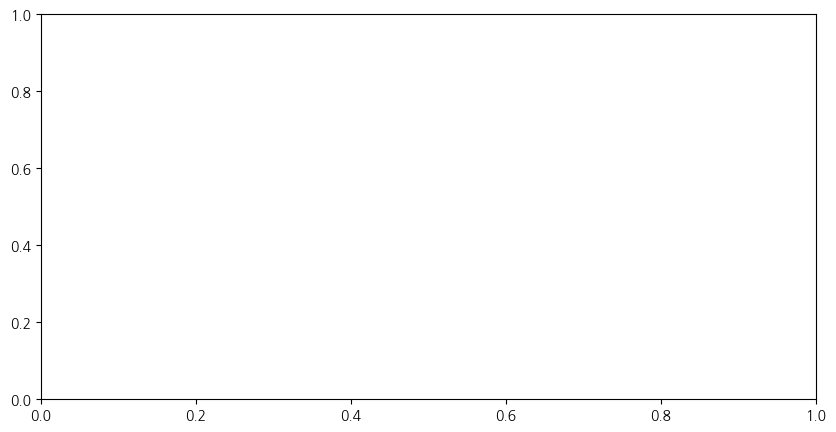

In [14]:
import matplotlib.pyplot as plt
from nilearn import plotting, image

print("Visualizing results...")

# T1w MNI 시각화
t1_mni = os.path.join(output_dir, "t1_mni.nii.gz")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, view in enumerate(['x', 'y', 'z']):
    plotting.plot_anat(t1_mni, display_mode=view, cut_coords=1, axes=axes[i])
plt.suptitle("T1w in MNI Space")
plt.savefig(os.path.join(output_dir, 'T1w_MNI_visualization.png'))
plt.close()

# fMRI MNI 시각화
bold_mni = os.path.join(output_dir, "bold_mni.nii.gz")
mean_img = image.mean_img(bold_mni)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, view in enumerate(['x', 'y', 'z']):
    plotting.plot_epi(mean_img, display_mode=view, cut_coords=1, axes=axes[i])
plt.suptitle("Mean fMRI in MNI Space")
plt.savefig(os.path.join(output_dir, 'fMRI_MNI_visualization.png'))
plt.close()

fig, ax = plt.subplots(figsize=(10, 5))
plotting.plot_glass_brain(mean_img, display_mode='ortho', colorbar=True, plot_abs=False)
plt.suptitle("Glass Brain View of Mean fMRI in MNI Space")
plt.savefig(os.path.join(output_dir, 'fMRI_glass_brain.png'))
plt.close()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import nibabel as nib
from nilearn import image
import os

print("Creating gif animation of fMRI data...")

# fMRI 데이터 로드
bold_mni = os.path.join(output_dir, "bold_mni.nii.gz")
fmri_img = nib.load(bold_mni)
fmri_data = fmri_img.get_fdata()

# 중간 슬라이스 선택
x, y, z, t = fmri_data.shape
slice_x, slice_y, slice_z = x // 2, y // 2, z // 2

# 데이터 정규화
fmri_data = (fmri_data - fmri_data.min()) / (fmri_data.max() - fmri_data.min())

# 그림 초기화
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle("fMRI Time Series")

# 초기 이미지 표시
im1 = ax1.imshow(fmri_data[slice_x, :, :, 0].T, cmap='viridis', animated=True)
im2 = ax2.imshow(fmri_data[:, slice_y, :, 0].T, cmap='viridis', animated=True)
im3 = ax3.imshow(fmri_data[:, :, slice_z, 0].T, cmap='viridis', animated=True)

ax1.set_title("Sagittal")
ax2.set_title("Coronal")
ax3.set_title("Axial")

# 컬러바 추가
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

# 애니메이션 업데이트 함수
def update(frame):
    im1.set_array(fmri_data[slice_x, :, :, frame].T)
    im2.set_array(fmri_data[:, slice_y, :, frame].T)
    im3.set_array(fmri_data[:, :, slice_z, frame].T)
    return [im1, im2, im3]

# 애니메이션 생성
anim = FuncAnimation(fig, update, frames=t, interval=50, blit=True)

# gif로 저장
anim.save(os.path.join(output_dir, 'fmri_animation.gif'), writer='pillow', fps=10)

plt.close()

print("Gif animation created and saved in the output directory.")

Creating gif animation of fMRI data...
Gif animation created and saved in the output directory.
